#Foreplay

In [1]:
# Importa le librerie necessarie
from google.colab import drive
from tqdm import tqdm
from scipy.optimize import minimize
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import pywt
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score, precision_score, confusion_matrix
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.pipeline import Pipeline
import time
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier




In [2]:
np.random.seed(35)

In [3]:
# Monta il drive di Google
drive.mount('/content/drive')

# Percorso del file CSV
file_path = '/content/drive/MyDrive/dataset/features.csv'

Mounted at /content/drive


In [4]:
def get_name_columns(df, first_electrode = None, second_electrode = None):
  if first_electrode != None and second_electrode != None:
    return [col for col in df.columns if first_electrode in col or second_electrode in col]


  name_columns = list(df.columns)
  name_columns.remove('target')
  return name_columns

In [5]:
import seaborn as sns
def correlation_feature(df,block_size,correlation_threshold = 0.8, subplot = True, noPlot = None, first_electrode = None, second_electrode = None):
  name_columns = get_name_columns(df,first_electrode, second_electrode)
  blocchi_colonne = []
  for i in range(0, len(name_columns), block_size):
      blocco = name_columns[i:i+block_size]
      blocchi_colonne.append(blocco)
  if noPlot == None:
    if subplot:
      fig, axs = plt.subplots(8, 5, figsize=(15, 20))   # 8 righe, 5 colonne
      plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Aggiunge spazio verticale tra i subplot
    else:
      fig = plt.figure(figsize=(10, 6))
      axs = fig.add_subplot(111)  # A single subplot

  features_to_keep  = []
  # Create a list of features to be removed
  features_to_remove = []


  correlation_dict = {}
  for n, blocco in enumerate(blocchi_colonne):
      corr_matrix  = df[blocco].corr()
      if noPlot == None:
        if subplot:
            ax = axs[n//5, n%5]  # Utilizza l'array axs per definire il subplot
        else:
            ax = axs

        sns.heatmap(corr_matrix , cmap='coolwarm', annot=True, fmt=".2f", cbar=True, ax=ax, annot_kws={"size": 5})  # Imposta la dimensione del testo delle etichette a 8
      if noPlot == None:
        if subplot:
          if n % 5 == 0:
              ax = axs[n//5, 0]  # Utilizza il primo subplot della riga
              ax.set_title(f'Electoroid {n//5 + 1}')  # Imposta il titolo del subplot
          else:
              ax = axs[n//5, n%5]
        ax.set_xticks(range(len(corr_matrix .columns)))
        ax.set_xticklabels(corr_matrix .columns, rotation=90)
        ax.set_yticks(range(len(corr_matrix .columns)))
        ax.set_yticklabels(corr_matrix .columns)

      # Scan the correlation matrix and identify features to be removed
      for i in range(0,len(corr_matrix.columns)):
        values = []
        if corr_matrix.columns[i] not in features_to_remove:
          features_to_keep.append(corr_matrix.columns[i])
          key = corr_matrix.columns[i]
        else:
          key = ""
        for j in range(i+1, len(corr_matrix.columns)):
          if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            # Add the highly correlated feature to the list of features to be removed
            if corr_matrix.columns[i] not in features_to_remove:
              features_to_remove.append(corr_matrix.columns[j])
              if key != "":
                values.append(corr_matrix.columns[j])
        if key != "":
          correlation_dict[key] = values
  if noPlot == None:
    plt.show()  # Mostra la figura con i subplot alla fine del ciclo
  return features_to_remove,correlation_dict


In [6]:
def delete_correlation(features_to_remove):
  # Elimina le colonne dal dataframe
  df.drop(features_to_remove, axis=1, inplace=True)
  return df

In [7]:
def print_correlation(correlation_dict):
#  for key in correlation_dict.keys():
#    values = correlation_dict[key]
#    print(f"{key},{values}\n")
  correlation_dict_copy = correlation_dict.copy()

  # Itera attraverso le coppie chiave-valore del dizionario
  for key, value in correlation_dict.items():
      if not value:
          # Se la lista associata alla chiave è vuota, rimuovi la coppia chiave-valore
          del correlation_dict_copy[key]

  #elimino le coppie key, value i quli valori sono vuoti
  correlation_dict_all = correlation_dict_copy
  feature_delete = []
  for key in correlation_dict_all.keys():
    for value_list in correlation_dict_all[key]:
      if value_list not in feature_delete:
        feature_delete.append(value_list)

  # vedeo quante feature per ogni elettorodo sono stati eliminate
  electroid = [0,0,0,0,0,0,0,0]
  for feature in feature_delete:
    for char in feature:
      if char.isdigit() and int(char) >= 0 and int(char) <= 7:
          electroid[int(char)] += 1
  for i, value in enumerate(electroid):
    removed = round(value / 50,2)
    print(f"For electroid {i+1}, {value}/50 -> {removed} values have been removed")

# Analysis of dataset(no)

Start extracts the csv file

In [8]:
np.random.seed(35)
df = pd.read_csv(file_path)
df.shape

(125, 401)

I want to see the correlation between all the brain waves of all the electrodes and possibly eliminate the correlations

## Correlation of each brain wave for each electrode

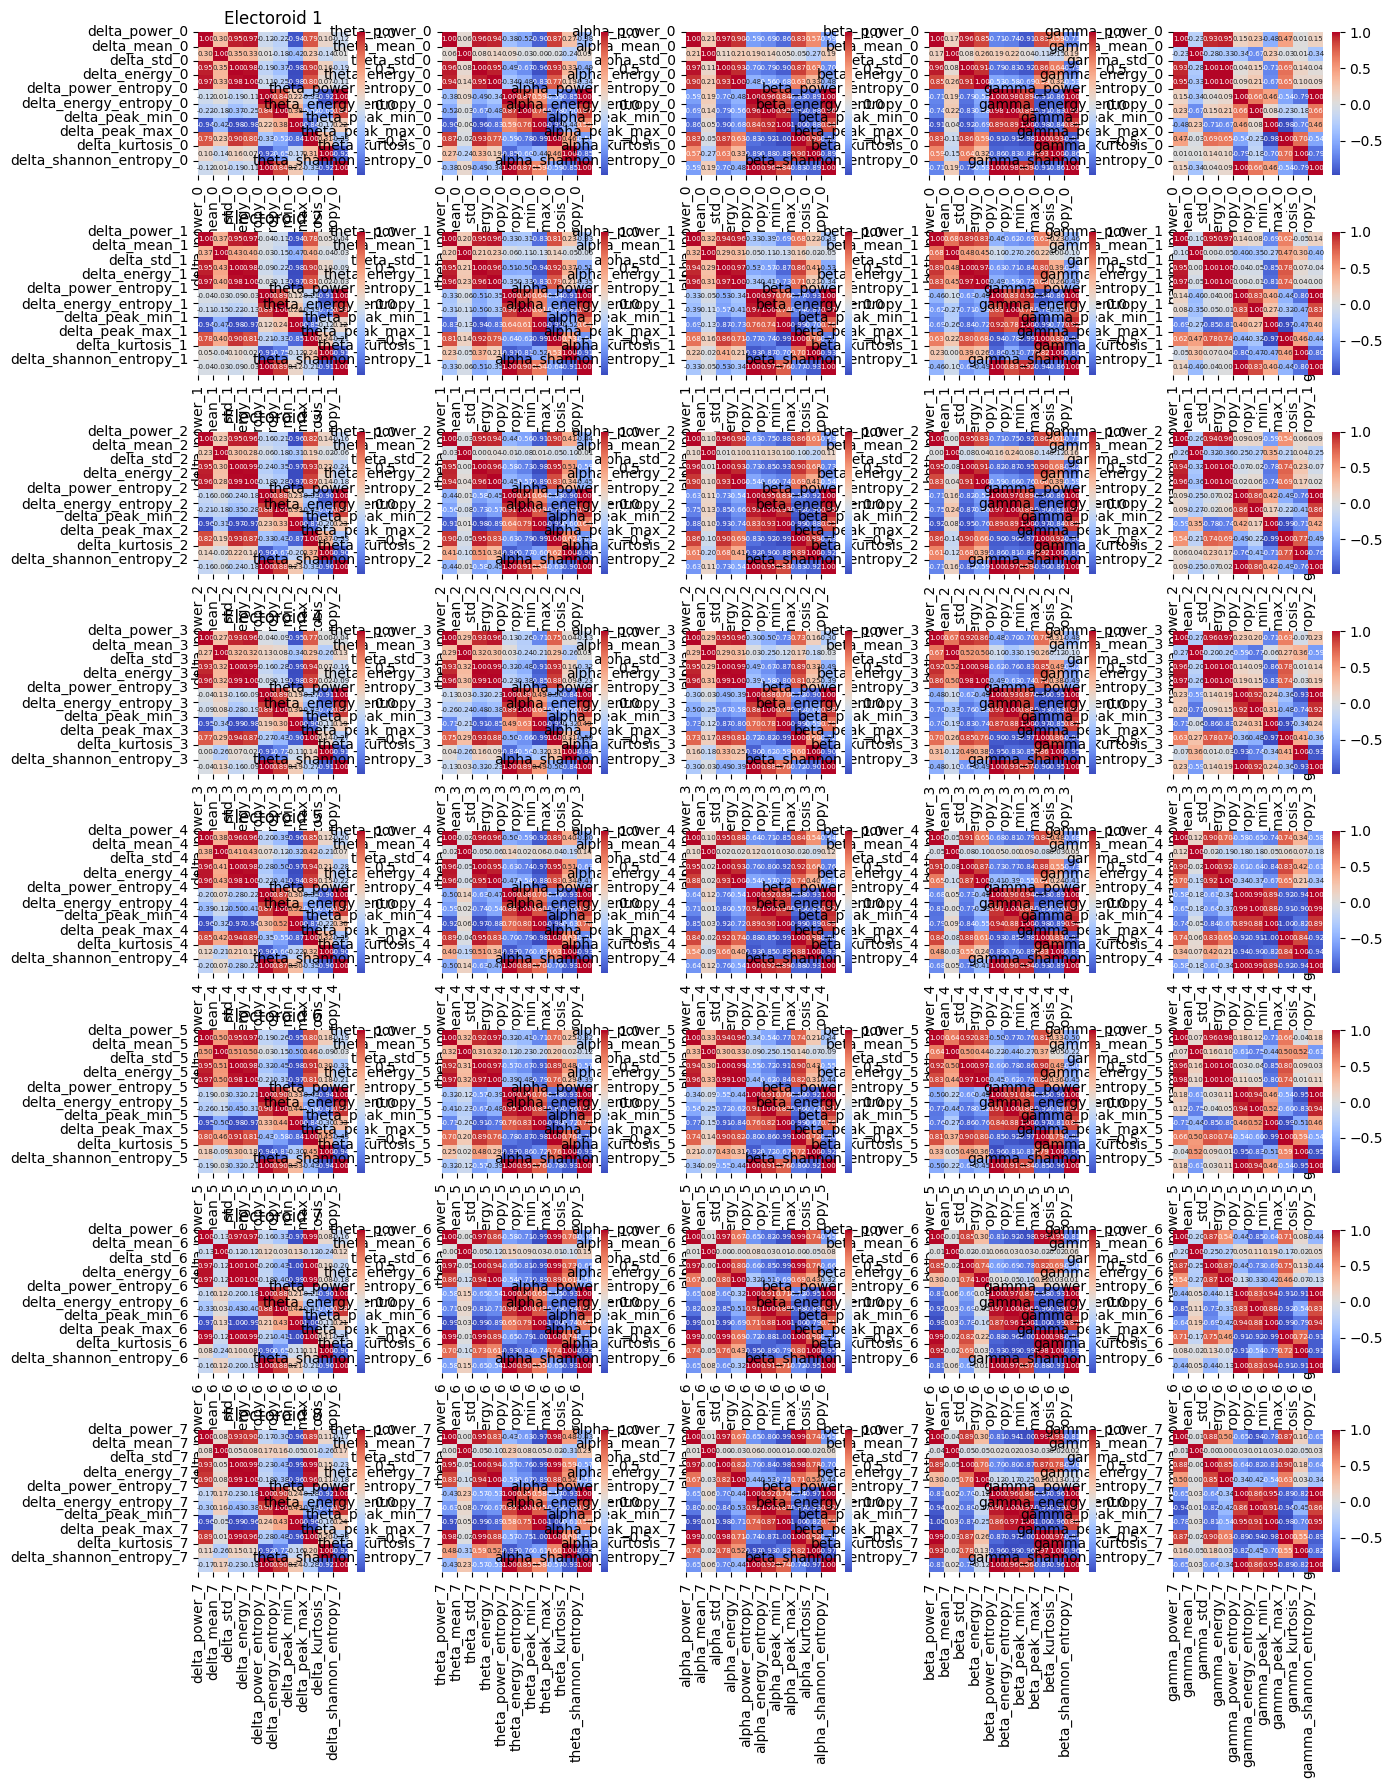

In [9]:
features_to_remove, correlation_dict = correlation_feature(df, 10, 0.8) #i want to show the correlations between each wave of each electrode
df = delete_correlation(features_to_remove)

In [10]:
df.shape

(125, 145)

## Correlation of each electrode with all its waves

### Electroide 0

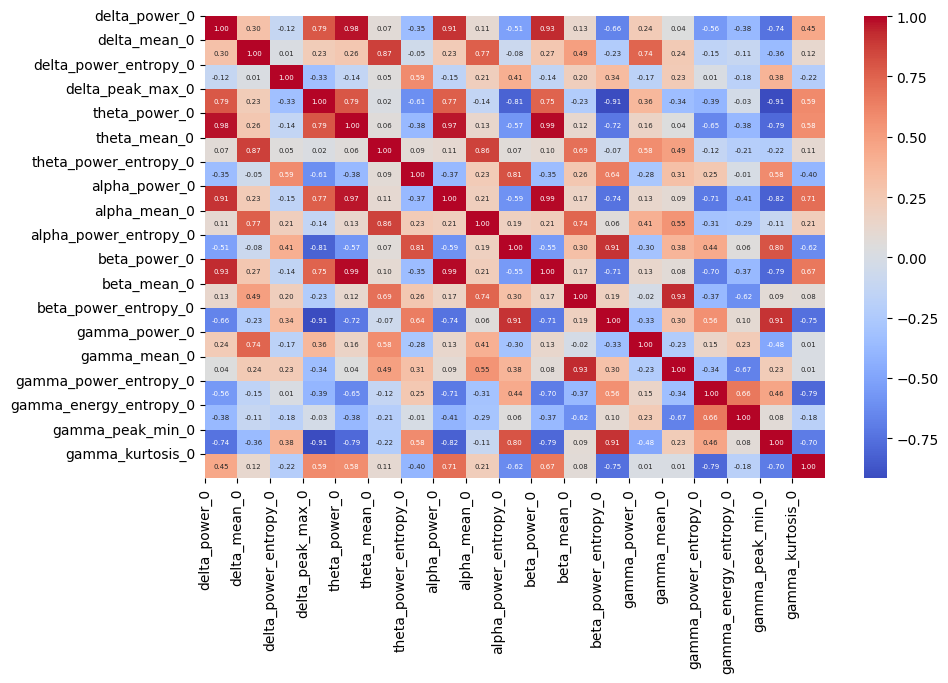

For electroid 1, 8/50 -> 0.16 values have been removed
For electroid 2, 0/50 -> 0.0 values have been removed
For electroid 3, 0/50 -> 0.0 values have been removed
For electroid 4, 0/50 -> 0.0 values have been removed
For electroid 5, 0/50 -> 0.0 values have been removed
For electroid 6, 0/50 -> 0.0 values have been removed
For electroid 7, 0/50 -> 0.0 values have been removed
For electroid 8, 0/50 -> 0.0 values have been removed


(125, 137)

In [11]:
features_to_remove, correlation_dict_0 = correlation_feature(df, df.shape[1], 0.8,subplot=False,first_electrode= "0",second_electrode= "0") #i want to show the correlations between of each electrode
print_correlation(correlation_dict_0)
df = delete_correlation(features_to_remove)
df.shape

### Electrode 1

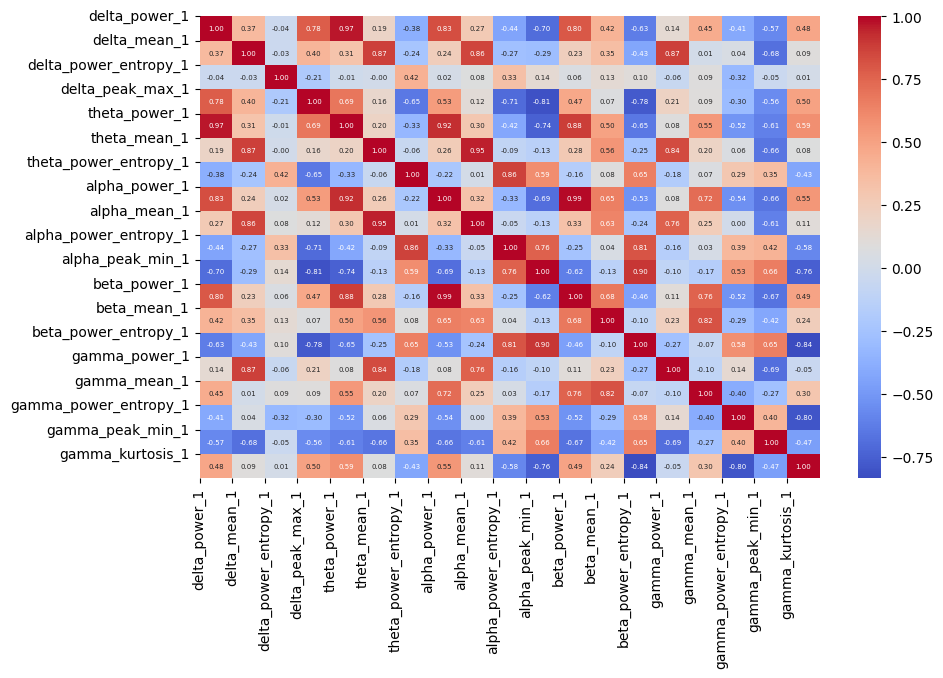

For electroid 1, 0/50 -> 0.0 values have been removed
For electroid 2, 9/50 -> 0.18 values have been removed
For electroid 3, 0/50 -> 0.0 values have been removed
For electroid 4, 0/50 -> 0.0 values have been removed
For electroid 5, 0/50 -> 0.0 values have been removed
For electroid 6, 0/50 -> 0.0 values have been removed
For electroid 7, 0/50 -> 0.0 values have been removed
For electroid 8, 0/50 -> 0.0 values have been removed


(125, 128)

In [12]:
features_to_remove, correlation_dict_1 = correlation_feature(df, df.shape[1], 0.8,subplot=False,first_electrode= "1",second_electrode= "1")
print_correlation(correlation_dict_1)
df = delete_correlation(features_to_remove)
df.shape

###Electrode 2

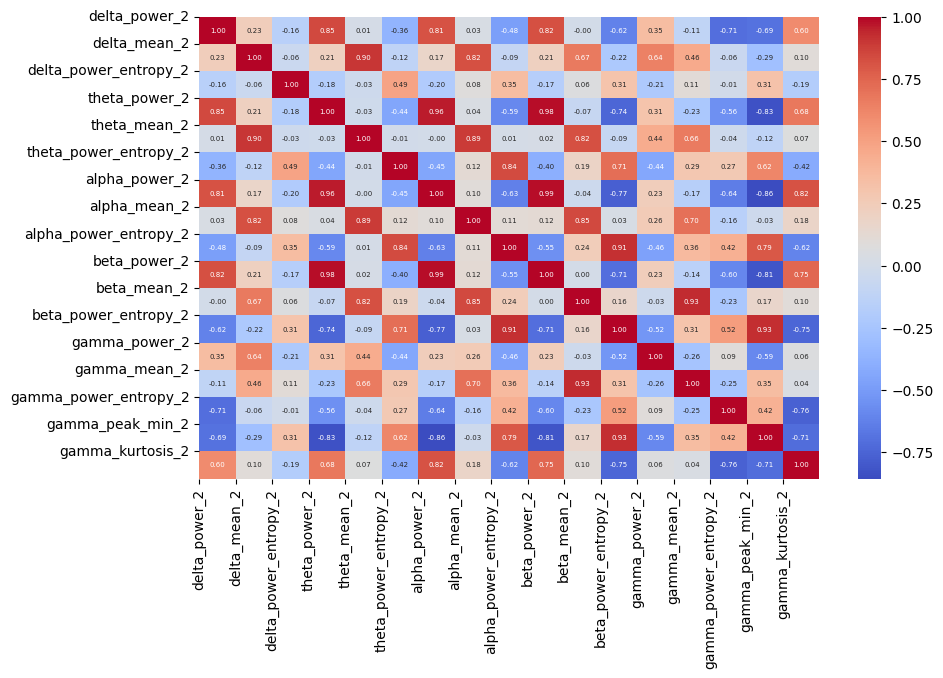

For electroid 1, 0/50 -> 0.0 values have been removed
For electroid 2, 0/50 -> 0.0 values have been removed
For electroid 3, 8/50 -> 0.16 values have been removed
For electroid 4, 0/50 -> 0.0 values have been removed
For electroid 5, 0/50 -> 0.0 values have been removed
For electroid 6, 0/50 -> 0.0 values have been removed
For electroid 7, 0/50 -> 0.0 values have been removed
For electroid 8, 0/50 -> 0.0 values have been removed


(125, 120)

In [13]:
features_to_remove, correlation_dict_2 = correlation_feature(df, df.shape[1], 0.8,subplot=False,first_electrode= "2",second_electrode= "2")
print_correlation(correlation_dict_2)
df = delete_correlation(features_to_remove)
df.shape

### Electrode 3

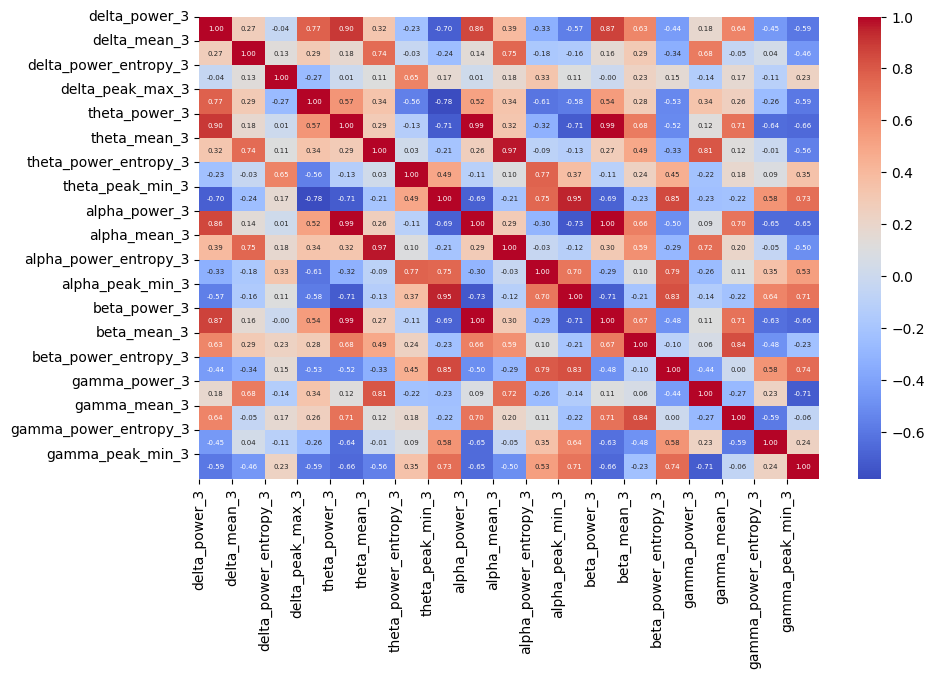

For electroid 1, 0/50 -> 0.0 values have been removed
For electroid 2, 0/50 -> 0.0 values have been removed
For electroid 3, 0/50 -> 0.0 values have been removed
For electroid 4, 8/50 -> 0.16 values have been removed
For electroid 5, 0/50 -> 0.0 values have been removed
For electroid 6, 0/50 -> 0.0 values have been removed
For electroid 7, 0/50 -> 0.0 values have been removed
For electroid 8, 0/50 -> 0.0 values have been removed


(125, 112)

In [14]:
features_to_remove, correlation_dict_3 = correlation_feature(df, df.shape[1], 0.8,subplot=False,first_electrode= "3",second_electrode= "3")
print_correlation(correlation_dict_3)
df = delete_correlation(features_to_remove)
df.shape

### Electrode 4

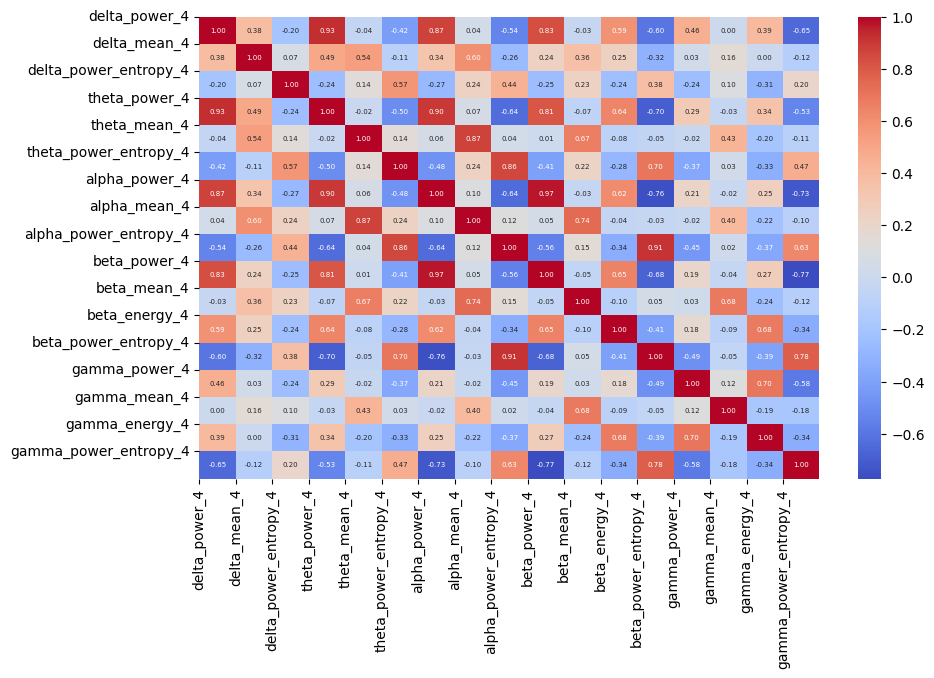

For electroid 1, 0/50 -> 0.0 values have been removed
For electroid 2, 0/50 -> 0.0 values have been removed
For electroid 3, 0/50 -> 0.0 values have been removed
For electroid 4, 0/50 -> 0.0 values have been removed
For electroid 5, 5/50 -> 0.1 values have been removed
For electroid 6, 0/50 -> 0.0 values have been removed
For electroid 7, 0/50 -> 0.0 values have been removed
For electroid 8, 0/50 -> 0.0 values have been removed


(125, 107)

In [15]:
features_to_remove, correlation_dict_4 = correlation_feature(df, df.shape[1], 0.8,subplot=False,first_electrode= "4",second_electrode= "4")
print_correlation(correlation_dict_4)
df = delete_correlation(features_to_remove)
df.shape

### Electrode 5

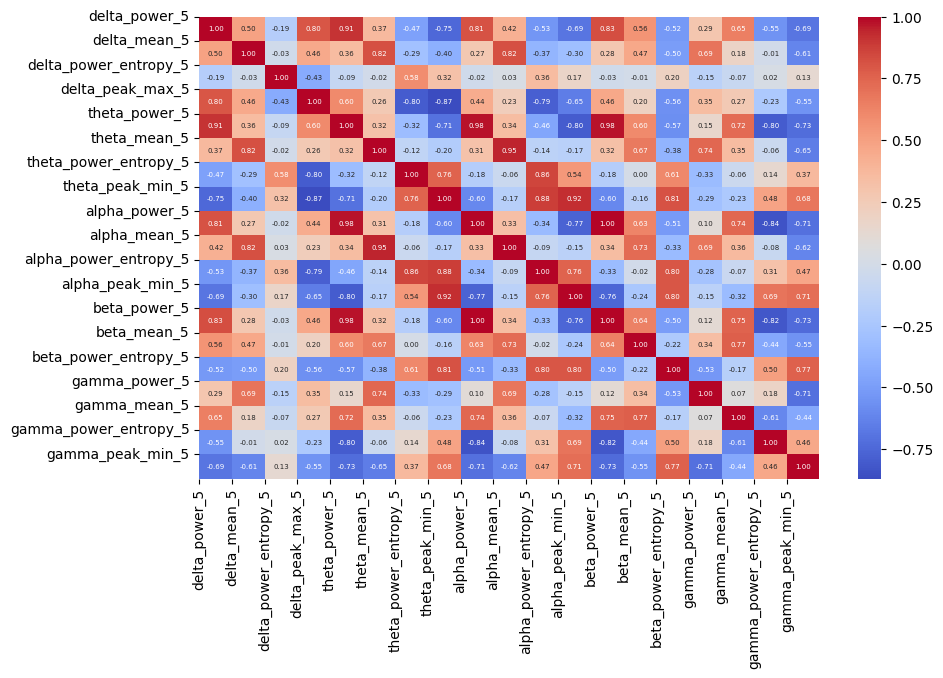

For electroid 1, 0/50 -> 0.0 values have been removed
For electroid 2, 0/50 -> 0.0 values have been removed
For electroid 3, 0/50 -> 0.0 values have been removed
For electroid 4, 0/50 -> 0.0 values have been removed
For electroid 5, 0/50 -> 0.0 values have been removed
For electroid 6, 8/50 -> 0.16 values have been removed
For electroid 7, 0/50 -> 0.0 values have been removed
For electroid 8, 0/50 -> 0.0 values have been removed


(125, 99)

In [16]:
features_to_remove, correlation_dict_5 = correlation_feature(df, df.shape[1], 0.8,subplot=False,first_electrode= "5",second_electrode= "5")
print_correlation(correlation_dict_5)
df = delete_correlation(features_to_remove)
df.shape

### Electrode 6

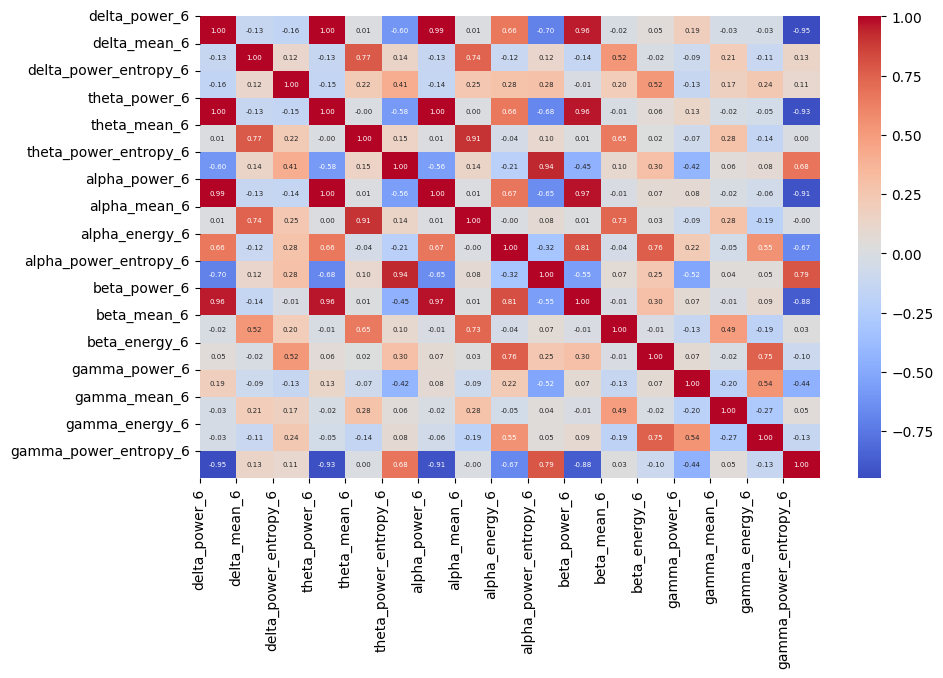

For electroid 1, 0/50 -> 0.0 values have been removed
For electroid 2, 0/50 -> 0.0 values have been removed
For electroid 3, 0/50 -> 0.0 values have been removed
For electroid 4, 0/50 -> 0.0 values have been removed
For electroid 5, 0/50 -> 0.0 values have been removed
For electroid 6, 0/50 -> 0.0 values have been removed
For electroid 7, 6/50 -> 0.12 values have been removed
For electroid 8, 0/50 -> 0.0 values have been removed


(125, 93)

In [17]:
features_to_remove, correlation_dict_6 = correlation_feature(df, df.shape[1], 0.8,subplot=False,first_electrode= "6",second_electrode= "6")
print_correlation(correlation_dict_6)
df = delete_correlation(features_to_remove)
df.shape

### Electrode 7

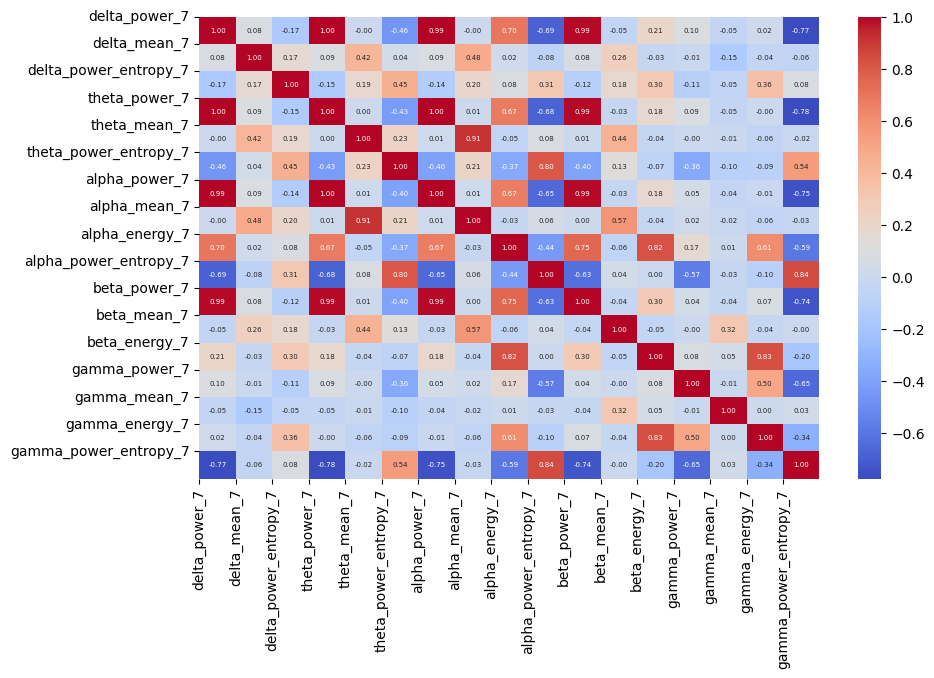

For electroid 1, 0/50 -> 0.0 values have been removed
For electroid 2, 0/50 -> 0.0 values have been removed
For electroid 3, 0/50 -> 0.0 values have been removed
For electroid 4, 0/50 -> 0.0 values have been removed
For electroid 5, 0/50 -> 0.0 values have been removed
For electroid 6, 0/50 -> 0.0 values have been removed
For electroid 7, 0/50 -> 0.0 values have been removed
For electroid 8, 6/50 -> 0.12 values have been removed


(125, 87)

In [18]:
features_to_remove, correlation_dict_7 = correlation_feature(df, df.shape[1], 0.8,subplot=False,first_electrode= "7",second_electrode= "7")
print_correlation(correlation_dict_7)
df = delete_correlation(features_to_remove)
df.shape

### All Electrode

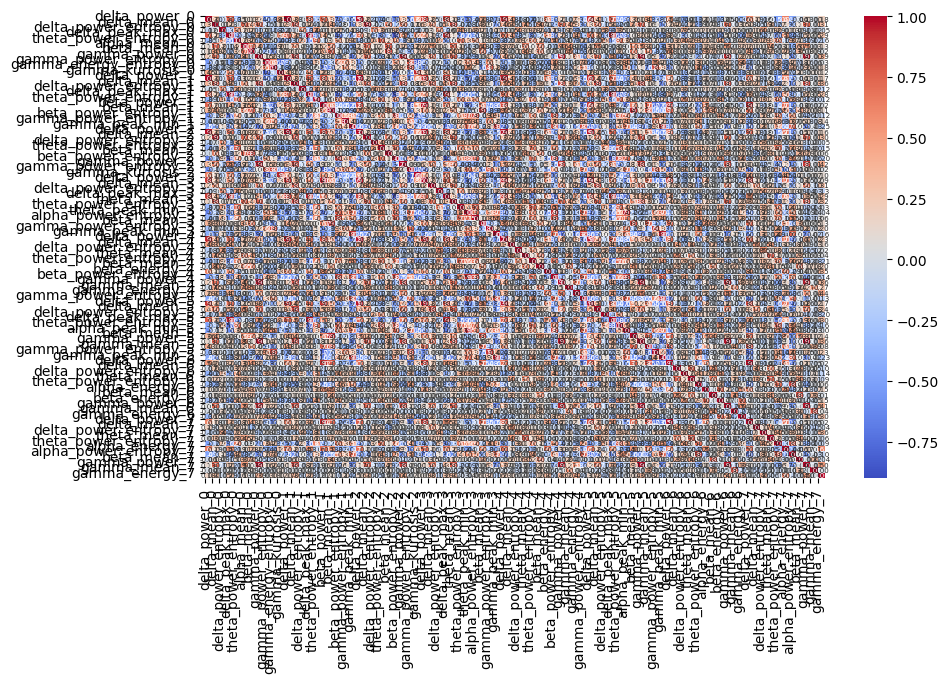

For electroid 1, 0/50 -> 0.0 values have been removed
For electroid 2, 3/50 -> 0.06 values have been removed
For electroid 3, 7/50 -> 0.14 values have been removed
For electroid 4, 7/50 -> 0.14 values have been removed
For electroid 5, 4/50 -> 0.08 values have been removed
For electroid 6, 9/50 -> 0.18 values have been removed
For electroid 7, 2/50 -> 0.04 values have been removed
For electroid 8, 5/50 -> 0.1 values have been removed


(125, 50)

In [19]:
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#Setting

## ROC plot

In [20]:
def plot_ROC(y_test, y_score):

  fpr, tpr, thresholds = roc_curve(y_test, y_score)

  # Crea una lista di soglie da 0.1 a 1 con passo di 0.1
  threshold_list = [x/10 for x in range(1, 11)]

  # Plot della curva ROC
  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
  plt.plot([0, 1], [0, 1], 'k--')  # Linea di riferimento per il caso casuale
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')

  # Plot delle soglie
  for threshold in threshold_list:
      plt.scatter(fpr[thresholds >= threshold][-1], tpr[thresholds >= threshold][-1], c='red')
      plt.annotate(f'Thsd: {threshold}', (fpr[thresholds >= threshold][-1], tpr[thresholds >= threshold][-1]),
                  textcoords="offset points", xytext=(-10,10), ha='center')


  # Calcola la distanza di Youden's J per ciascuna soglia
  youden_j = tpr - fpr

  # Trova l'indice della soglia che massimizza Youden's J
  best_threshold_index = np.argmax(youden_j)

  # Ottieni la migliore soglia
  best_threshold = thresholds[best_threshold_index]

  if best_threshold > 1:
    best_threshold =  best_threshold -1
  print("Best threshold:", best_threshold)


  plt.show()

  return best_threshold

##Param GridSearchCV

In [21]:
# def param_grid(n_feature, lessDeep = False):
#   k_ = []
#   for i in range(1,n_feature+1,2):
#     k_.append(i)

#   if lessDeep == True :
#     max_depth_ = 2
#   else:
#     max_depth_ = 4

#   param_grid = [
#     {
#         'feature_selection__k': k_,
#         'classifier': [SVC(kernel='linear')],
#         'classifier__C': [0.1, 1, 10]
#     },
#     {
#         'feature_selection__k': k_,
#         'classifier': [SVC(kernel='rbf')],
#         'classifier__C': [0.1, 1, 10],
#         'classifier__gamma': [0.1, 1, 10]
#     },
#     {
#         'feature_selection__k': k_,
#         'classifier': [KNeighborsClassifier()],
#         'classifier__n_neighbors': [3, 5, 7],
#         'classifier__weights': ['uniform', 'distance']
#     },
#     {
#         'feature_selection__k': k_,
#         'classifier': [DecisionTreeClassifier()],
#         'classifier__max_depth': [3, 5, 10, None],
#         'classifier__min_samples_split': [2, 5, 10]
#     },
#     {
#         'feature_selection__k': k_,
#         'classifier': [RandomForestClassifier()],
#         'classifier__n_estimators': [50, 100, 200],
#         'classifier__max_depth': [3, 5, 10, None],
#         'classifier__min_samples_split': [2, 5, 10]
#     },
#     {
#         'feature_selection__k': k_,
#         'classifier': [LogisticRegression()],
#         'classifier__C': [0.1, 1, 10]
#     },
#     {
#         'feature_selection__k': k_,
#         'classifier': [GradientBoostingClassifier()],
#         'classifier__n_estimators': [50, 100, 200],
#         'classifier__learning_rate': [0.01, 0.1, 1],
#         'classifier__max_depth': [3, 5, 10, None]
#     }
# ]

#   # DecisionTreeClassifier(max_depth=max_depth_), RandomForestClassifier(max_depth=max_depth_),
#   return param_grid

## Pipeline

In [22]:
def pipeline():
  # Definizione della pipeline con GridSearchCV
  estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest()), ('classifier', LogisticRegression())]

  pipe = Pipeline(estimators)
  return pipe

## StratifiedKFold

In [23]:
import pickle
def SFK(n_folds):
  cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  fold_indices = []
  for train_index, test_index in cv.split(X, y):
      fold_indices.append((train_index, test_index))
  # Salva fold_indices in un file
  with open('/content/drive/MyDrive/dataset/fold_indices.pkl', 'wb') as file:
      pickle.dump(fold_indices, file)
  return cv

## GridSearchCV

In [24]:
def gridSearch(scoring,X,y,lessDeep = False):
  cv = SFK(5)
  # Creazione dell'oggetto GridSearchCV
  grid_search = GridSearchCV(pipeline(), param_grid(X.shape[1],lessDeep), scoring=scoring, cv=cv, refit="f1_score",error_score='raise',verbose= 0)

  # Eseguire la ricerca degli iperparametri con la cross-validation
  start_time = time.time()
  grid_search.fit(X, y)
  end_time = time.time()

  # Ottenere i risultati
  #best_params = grid_search.best_params_
  best_estimator = grid_search.best_estimator_
  #best_score = grid_search.best_score_
  #cv_results = grid_search.cv_results_
  #best_index_f1 = grid_search.best_index_
  y_pred = cross_val_predict(best_estimator, X, y, cv=cv)

  total_time = end_time - start_time
  return grid_search, best_estimator, total_time, y_pred

In [25]:
def plot_report_roc(scoring,grid_search,best_estimator,X,y):
  # Ottenere le previsioni del modello migliore
  y_pred = best_estimator.predict(X)

  # Calcolare la matrice di confusione
  confusion_mat = confusion_matrix(y, y_pred)
  print("Matrice di confusione:")
  print(confusion_mat)

  # Calcolare il report di accuratezza, recall, precision e F1-score
  report = classification_report(y, y_pred)

    # Esempio di ottenere i risultati della GridSearch
  results = pd.DataFrame(grid_search.cv_results_)

  # Esempio di salvataggio dei risultati in un file CSV
  results.to_csv(f'/content/drive/MyDrive/dataset/{scoring}_grid_search_results.csv', index=False)

  print("Report di classificazione:")
  print(report)
  print(best_estimator.get_params())


  fpr, tpr, thresholds = roc_curve(y, y_pred)  # y_true sono le etichette vere, y_scores sono i punteggi previsti
  roc_auc = auc(fpr, tpr)

  # Plotta la curva ROC
  plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', alpha=0.5)  # Linea di riferimento per il caso randomico
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()
  return y_pred

Questa funzione peremtte di estrarre i valori migliori di f1_score, recall, precision e accuracy dalla grid_search

In [26]:
def best_score(grid_search ):
  scoring = ["f1_score", "recall", "precision", "accuracy" ]
  for metric in scoring:
    best_score = max(grid_search.cv_results_[f"mean_test_{metric}"])
    idx = np.where(grid_search.cv_results_[f"mean_test_{metric}"] == best_score )[0][0]
    # cicla tutte le chiavi presenti all'interno del vocabolario cv_results_
    n_fold = 0
    print(f"------------{metric}----------------")
    print(f"BEST SCORE: {best_score}\n")
    print("The values of each fold are:")
    for key in grid_search.cv_results_.keys():
        if "mean" in key or "std" in key or "rank" in key:
          continue
        if f"test_{metric}" in key:
          print(f"{key} _fold_{n_fold}: {grid_search.cv_results_[key][idx]}")
          n_fold = n_fold +1
    print("\n\n")

# RandomForestClassifier

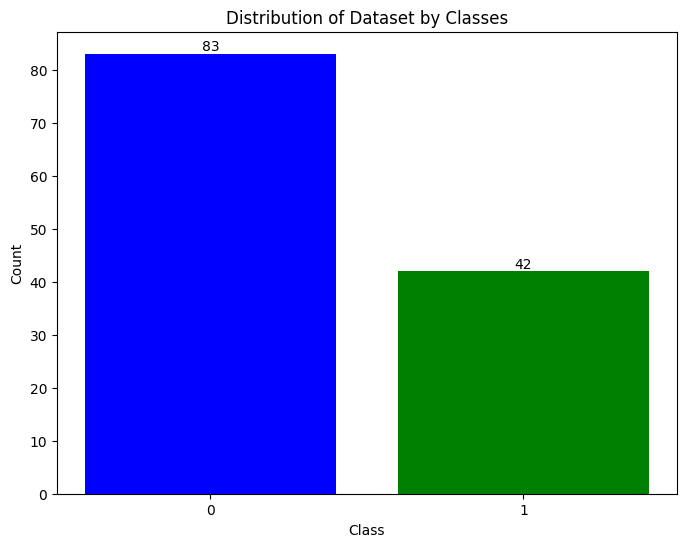

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Code for loading and preprocessing the dataset

# Plotting the distribution of dataset by classes 0 and 1
class_labels = [0, 1]
colors = ['blue', 'green']

plt.figure(figsize=(8, 6))
for class_label, color in zip(class_labels, colors):
    class_count = df[df['target'] == class_label].shape[0]
    plt.bar(str(class_label), class_count, color=color)
    plt.text(str(class_label), class_count, str(class_count), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Dataset by Classes')
plt.show()


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed


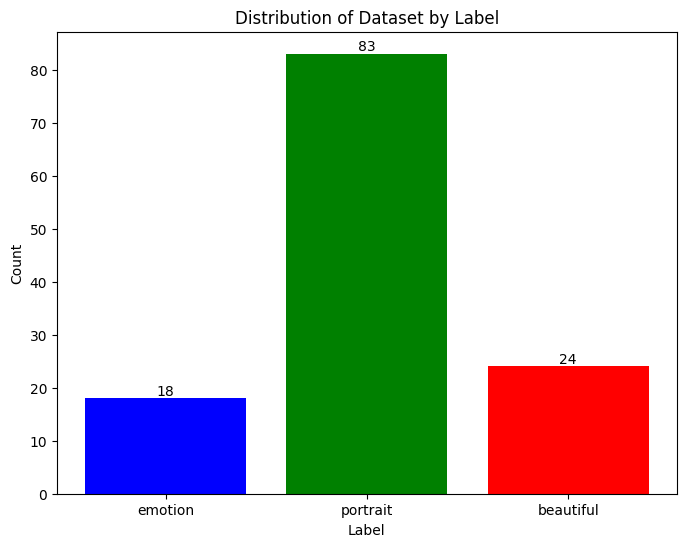

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape


# Plot della distribuzione del dataset per le etichette 'emotion', 'portrait' e 'beautiful'
labels = ['emotion', 'portrait', 'beautiful']
colors = ['blue', 'green', 'red']

plt.figure(figsize=(8, 6))
for label, color in zip(labels, colors):
    target_count = df[df['target'] == label].shape[0]
    plt.bar(label, target_count, color=color)
    plt.text(label, target_count, str(target_count), ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Dataset by Label')
plt.show()

# Splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']



In [14]:
def param_grid(n_feature, lessDeep = False):
  k_ = []
  for i in range(1,n_feature+1,2):
    k_.append(i)

  if lessDeep == True :
    max_depth_ = 2
  else:
    max_depth_ = 4

  param_grid = [
    {
        'feature_selection__k': k_,
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
]

  # DecisionTreeClassifier(max_depth=max_depth_), RandomForestClassifier(max_depth=max_depth_),
  return param_grid

In [15]:
#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed


In [ ]:
scoring = {
    'f1_score': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}



grid_search, best_estimator, total_time, y_pred = gridSearch(scoring, X, y)

# Salvare il modello migliore come file pickle
with open('/content/drive/MyDrive/dataset/best_model_f1_score1.pkl', 'wb') as file:
    pickle.dump(best_estimator, file)
# Caricare il modello salvato
with open('/content/drive/MyDrive/dataset/best_model_f1_score.pkl', 'rb') as file:
    best_estimator = pickle.load(file)
best_params = grid_search.best_params_

In [ ]:
best_params

{'classifier': RandomForestClassifier(max_depth=10, n_estimators=200),
 'classifier__max_depth': 10,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 200,
 'feature_selection__k': 1}

In [ ]:
# Estrazione del classificatore
best_classifier = best_params['classifier']
copy_best_param = best_params.copy()
del copy_best_param['classifier']

# Estrazione degli altri iperparametri
max_depth = best_params['classifier__max_depth']
min_samples_split = best_params['classifier__min_samples_split']
n_estimators = best_params['classifier__n_estimators']
feature_selection__k = best_params['feature_selection__k']

best_classifier = best_classifier.set_params(max_depth=max_depth, min_samples_split= min_samples_split, n_estimators=n_estimators)



In [ ]:
# # Split del dataset in set di allenamento e test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# smote = SMOTE()

# # Applicazione di SMOTE su X_train e y_train
# X_train, y_train = smote.fit_resample(X_train, y_train)

# # Verifica delle dimensioni dei set di allenamento e test
# print("Dimensione di X_train:", X_train.shape)
# print("Dimensione di X_test:", X_test.shape)
# print("Dimensione di y_train:", y_train.shape)
# print("Dimensione di y_test:", y_test.shape)

# # Stampo quanti valori ho per ogni classe
# print("Conteggio per ciascun valore in y:\n", count_per_value)

Dimensione di X_train: (130, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (130,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


In [ ]:
# def apply_threshold(y_scores, threshold):
#     return (y_scores >= threshold).astype(int)

In [ ]:
# threshold_best

0.35

In [ ]:
# #------------------------------------------#

# #scores = cross_validate(best_estimator, X, y, cv=skf ,scoring='f1', return_train_score=True) # NON LA USO PERCHE' NON TROVO IL MODO PER MODIFICARE IL THRESHOLD
# #print(scores['test_score'])


# #------------------------------------------#

# # cross_validate
# f1_scores = []

# # Esegui la cross-validation con la funzione cross_val_predict
# for train_index, test_index in skf.split(X, y):
#     X_train_, X_test_ = X.values[train_index], X.values[test_index]
#     y_train_, y_test_ = y.values[train_index], y.values[test_index]

#     # Addestra il modello sul training set
#     best_estimator.fit(X_train_, y_train_)

#     # Ottieni le probabilità predette
#     y_scores_ = best_estimator.predict_proba(X_test_)[:, 1]

#     # Applica il threshold alle previsioni
#     y_pred = apply_threshold(y_scores_, threshold_best)

#     # Calcola l'F1-score per il fold corrente
#     f1_ = f1_score(y_test_, y_pred)

#     # Aggiungi l'F1-score alla lista
#     f1_scores.append(f1_)

# # Stampa l'F1-score per ogni fold
# print("F1-score per ogni fold:", f1_scores)



F1-score per ogni fold: [0.5, 0.26666666666666666, 0.4210526315789474, 0.35294117647058826, 0.35294117647058826]


In [ ]:
# estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=feature_selection__k)), ('classifier', best_classifier)]
# pipe = Pipeline(estimators)
# pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=1)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=200))])

In [ ]:
# y_scores = pipe.predict_proba(X_test)[:, 1]  # Probabilità delle classi positive
# y_pred = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
# print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.39      0.54        18
           1       0.35      0.86      0.50         7

    accuracy                           0.52        25
   macro avg       0.61      0.62      0.52        25
weighted avg       0.73      0.52      0.53        25



In [ ]:
# confusion_mat = confusion_matrix(y_test, y_pred)
# print("Matrice di confusione:")
# print(confusion_mat)

Matrice di confusione:
[[ 7 11]
 [ 1  6]]


# DecisionTreeClassifier

In [ ]:
def param_grid(n_feature, lessDeep = False):
  k_ = []
  for i in range(1,n_feature+1,2):
    k_.append(i)

  if lessDeep == True :
    max_depth_ = 2
  else:
    max_depth_ = 4

  param_grid = [
    {
        'feature_selection__k': k_,
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
]

  # DecisionTreeClassifier(max_depth=max_depth_), RandomForestClassifier(max_depth=max_depth_),
  return param_grid

In [ ]:
#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed


In [ ]:
scoring = {
    'f1_score': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}



grid_search, best_estimator, total_time, y_pred = gridSearch(scoring, X, y)

# Salvare il modello migliore come file pickle
with open('/content/drive/MyDrive/dataset/best_model_f1_score1.pkl', 'wb') as file:
    pickle.dump(best_estimator, file)
# Caricare il modello salvato
with open('/content/drive/MyDrive/dataset/best_model_f1_score.pkl', 'rb') as file:
    best_estimator = pickle.load(file)
best_params = grid_search.best_params_

In [ ]:
best_params

{'classifier': DecisionTreeClassifier(min_samples_split=5),
 'classifier__max_depth': None,
 'classifier__min_samples_split': 5,
 'feature_selection__k': 11}

In [ ]:
# Estrazione del classificatore
best_classifier = best_params['classifier']
copy_best_param = best_params.copy()
del copy_best_param['classifier']

# Estrazione degli altri iperparametri
max_depth = best_params['classifier__max_depth']
min_samples_split = best_params['classifier__min_samples_split']
feature_selection__k = best_params['feature_selection__k']

best_classifier = best_classifier.set_params(max_depth=max_depth, min_samples_split= min_samples_split)

In [ ]:
# Split del dataset in set di allenamento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

smote = SMOTE()

# Applicazione di SMOTE su X_train e y_train
X_train, y_train = smote.fit_resample(X_train, y_train)

# Verifica delle dimensioni dei set di allenamento e test
print("Dimensione di X_train:", X_train.shape)
print("Dimensione di X_test:", X_test.shape)
print("Dimensione di y_train:", y_train.shape)
print("Dimensione di y_test:", y_test.shape)

# Stampo quanti valori ho per ogni classe
print("Conteggio per ciascun valore in y:\n", count_per_value)

Dimensione di X_train: (130, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (130,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


In [ ]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

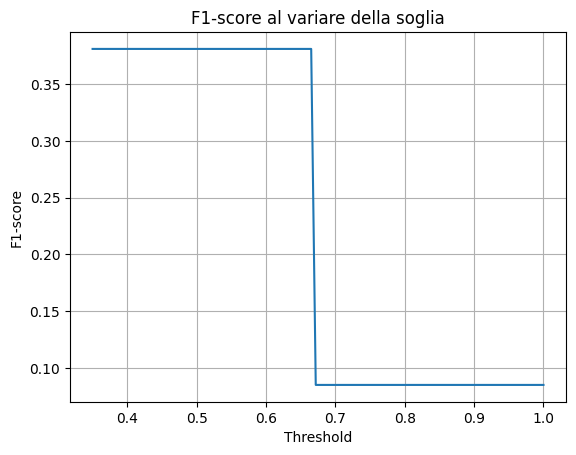

In [ ]:
# crea un oggetto StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0.35, 1, num=100)  # Array di soglie da 0 a 1


y_scores = cross_val_predict(estimator=best_estimator, X=X, y=y, cv=skf, method='predict_proba')[:, 1]  # Probabilità delle classi positive

threshold_best = 0
f1_value = 0
f1_scores = []
for threshold in thresholds:
    y_pred = apply_threshold(y_scores, threshold)  # Applicazione della soglia
    f1 = f1_score(y, y_pred)  # Calcolo dell'F1-score
    if (f1_value < f1 and threshold != 0 and threshold != 1):
      f1_value = f1
      threshold_best = threshold
    f1_scores.append(f1)

# Plot dell'F1-score al variare della soglia
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score al variare della soglia')
plt.grid(True)
plt.show()



In [ ]:
threshold_best

0.35

In [ ]:
#------------------------------------------#

#scores = cross_validate(best_estimator, X, y, cv=skf ,scoring='f1', return_train_score=True) # NON LA USO PERCHE' NON TROVO IL MODO PER MODIFICARE IL THRESHOLD
#print(scores['test_score'])


#------------------------------------------#

# cross_validate
f1_scores = []

# Esegui la cross-validation con la funzione cross_val_predict
for train_index, test_index in skf.split(X, y):
    X_train_, X_test_ = X.values[train_index], X.values[test_index]
    y_train_, y_test_ = y.values[train_index], y.values[test_index]

    # Addestra il modello sul training set
    best_estimator.fit(X_train_, y_train_)

    # Ottieni le probabilità predette
    y_scores_ = best_estimator.predict_proba(X_test_)[:, 1]

    # Applica il threshold alle previsioni
    y_pred = apply_threshold(y_scores_, threshold_best)

    # Calcola l'F1-score per il fold corrente
    f1_ = f1_score(y_test_, y_pred)

    # Aggiungi l'F1-score alla lista
    f1_scores.append(f1_)

# Stampa l'F1-score per ogni fold
print("F1-score per ogni fold:", f1_scores)



F1-score per ogni fold: [0.5, 0.26666666666666666, 0.4210526315789474, 0.35294117647058826, 0.35294117647058826]


In [ ]:
estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=feature_selection__k)), ('classifier', best_classifier)]
pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=11)),
                ('classifier', DecisionTreeClassifier(min_samples_split=5))])

In [ ]:
threshold = f1_value
y_scores = pipe.predict_proba(X_test)[:, 1]  # Probabilità delle classi positive
y_pred = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.44      0.52        18
           1       0.17      0.29      0.21         7

    accuracy                           0.40        25
   macro avg       0.39      0.37      0.36        25
weighted avg       0.49      0.40      0.43        25



In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred)
print("Matrice di confusione:")
print(confusion_mat)

Matrice di confusione:
[[ 8 10]
 [ 5  2]]


# GradientBoostingClassifier

In [ ]:
def param_grid(n_feature, lessDeep = False):
  k_ = []
  for i in range(1,n_feature+1,2):
    k_.append(i)

  if lessDeep == True :
    max_depth_ = 2
  else:
    max_depth_ = 4

  param_grid = [
   {
        'feature_selection__k': k_,
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__max_depth': [3, 5, 10, None]
    }
]

  # DecisionTreeClassifier(max_depth=max_depth_), RandomForestClassifier(max_depth=max_depth_),
  return param_grid

In [ ]:
#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed


In [ ]:
scoring = {
    'f1_score': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}



grid_search, best_estimator, total_time, y_pred = gridSearch(scoring, X, y)

# Salvare il modello migliore come file pickle
with open('/content/drive/MyDrive/dataset/best_model_f1_score1.pkl', 'wb') as file:
    pickle.dump(best_estimator, file)
# Caricare il modello salvato
with open('/content/drive/MyDrive/dataset/best_model_f1_score.pkl', 'rb') as file:
    best_estimator = pickle.load(file)
best_params = grid_search.best_params_

In [ ]:
best_params

{'classifier': GradientBoostingClassifier(learning_rate=1, max_depth=None),
 'classifier__learning_rate': 1,
 'classifier__max_depth': None,
 'classifier__n_estimators': 100,
 'feature_selection__k': 11}

In [ ]:
# Estrazione del classificatore
best_classifier = best_params['classifier']
copy_best_param = best_params.copy()
del copy_best_param['classifier']

# Estrazione degli altri iperparametri
learning_rate = best_params['classifier__learning_rate']
max_depth = best_params['classifier__max_depth']
n_estimators = best_params['classifier__n_estimators']
feature_selection__k = best_params['feature_selection__k']


best_classifier = best_classifier.set_params(learning_rate=learning_rate, max_depth= max_depth, n_estimators=n_estimators)

In [ ]:
# Split del dataset in set di allenamento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

smote = SMOTE()

# Applicazione di SMOTE su X_train e y_train
X_train, y_train = smote.fit_resample(X_train, y_train)

# Verifica delle dimensioni dei set di allenamento e test
print("Dimensione di X_train:", X_train.shape)
print("Dimensione di X_test:", X_test.shape)
print("Dimensione di y_train:", y_train.shape)
print("Dimensione di y_test:", y_test.shape)

# Stampo quanti valori ho per ogni classe
print("Conteggio per ciascun valore in y:\n", count_per_value)

Dimensione di X_train: (130, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (130,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


In [ ]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

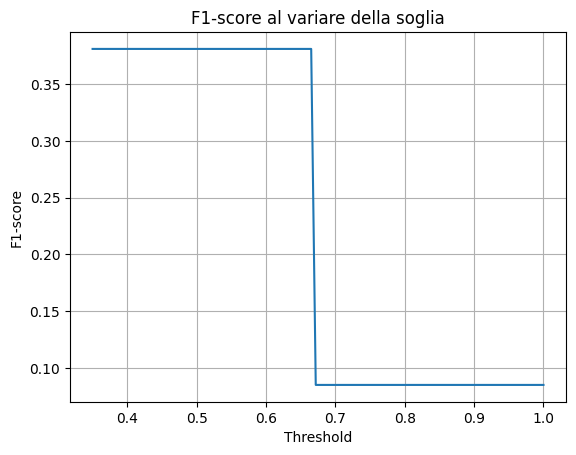

In [ ]:
# crea un oggetto StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0.35, 1, num=100)  # Array di soglie da 0 a 1


y_scores = cross_val_predict(estimator=best_estimator, X=X, y=y, cv=skf, method='predict_proba')[:, 1]  # Probabilità delle classi positive

threshold_best = 0
f1_value = 0
f1_scores = []
for threshold in thresholds:
    y_pred = apply_threshold(y_scores, threshold)  # Applicazione della soglia
    f1 = f1_score(y, y_pred)  # Calcolo dell'F1-score
    if (f1_value < f1 and threshold != 0 and threshold != 1):
      f1_value = f1
      threshold_best = threshold
    f1_scores.append(f1)

# Plot dell'F1-score al variare della soglia
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score al variare della soglia')
plt.grid(True)
plt.show()



In [ ]:
threshold_best

0.35

In [ ]:
#------------------------------------------#

#scores = cross_validate(best_estimator, X, y, cv=skf ,scoring='f1', return_train_score=True) # NON LA USO PERCHE' NON TROVO IL MODO PER MODIFICARE IL THRESHOLD
#print(scores['test_score'])


#------------------------------------------#

# cross_validate
f1_scores = []

# Esegui la cross-validation con la funzione cross_val_predict
for train_index, test_index in skf.split(X, y):
    X_train_, X_test_ = X.values[train_index], X.values[test_index]
    y_train_, y_test_ = y.values[train_index], y.values[test_index]

    # Addestra il modello sul training set
    best_estimator.fit(X_train_, y_train_)

    # Ottieni le probabilità predette
    y_scores_ = best_estimator.predict_proba(X_test_)[:, 1]

    # Applica il threshold alle previsioni
    y_pred = apply_threshold(y_scores_, threshold_best)

    # Calcola l'F1-score per il fold corrente
    f1_ = f1_score(y_test_, y_pred)

    # Aggiungi l'F1-score alla lista
    f1_scores.append(f1_)

# Stampa l'F1-score per ogni fold
print("F1-score per ogni fold:", f1_scores)



F1-score per ogni fold: [0.5, 0.26666666666666666, 0.4210526315789474, 0.35294117647058826, 0.35294117647058826]


In [ ]:
estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=feature_selection__k)), ('classifier', best_classifier)]
pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=11)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=1, max_depth=None))])

In [ ]:
threshold = f1_value
y_scores = pipe.predict_proba(X_test)[:, 1]  # Probabilità delle classi positive
y_pred = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.50      0.29      0.36         7

    accuracy                           0.72        25
   macro avg       0.63      0.59      0.59        25
weighted avg       0.69      0.72      0.69        25



In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred)
print("Matrice di confusione:")
print(confusion_mat)

Matrice di confusione:
[[16  2]
 [ 5  2]]


#ExtraTreesClassifier

In [ ]:
def param_grid(n_feature, lessDeep=False):
    k_ = []
    for i in range(1, n_feature + 1, 2):
        k_.append(i)

    if lessDeep == True:
        max_depth_ = 2
    else:
        max_depth_ = 4

    param_grid = [
        {
            'feature_selection__k': k_,
            'classifier': [ExtraTreesClassifier()],
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 5, 10, None],
            'classifier__min_samples_split': [2, 5, 10]
        }
    ]

    return param_grid


In [ ]:
#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed


In [ ]:
scoring = {
    'f1_score': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}



grid_search, best_estimator, total_time, y_pred = gridSearch(scoring, X, y)

# Salvare il modello migliore come file pickle
with open('/content/drive/MyDrive/dataset/best_model_f1_score1.pkl', 'wb') as file:
    pickle.dump(best_estimator, file)
# Caricare il modello salvato
with open('/content/drive/MyDrive/dataset/best_model_f1_score.pkl', 'rb') as file:
    best_estimator = pickle.load(file)
best_params = grid_search.best_params_

In [ ]:
best_params

{'classifier': ExtraTreesClassifier(),
 'classifier__max_depth': None,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 100,
 'feature_selection__k': 5}

In [ ]:
# Estrazione del classificatore
best_classifier = best_params['classifier']
copy_best_param = best_params.copy()
del copy_best_param['classifier']

# Estrazione degli altri iperparametri
max_depth = best_params['classifier__max_depth']
min_samples_split = best_params['classifier__min_samples_split']
n_estimators = best_params['classifier__n_estimators']
feature_selection__k = best_params['feature_selection__k']


best_classifier = best_classifier.set_params(min_samples_split=min_samples_split, max_depth= max_depth, n_estimators=n_estimators)

In [ ]:
# Split del dataset in set di allenamento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

smote = SMOTE()

# Applicazione di SMOTE su X_train e y_train
X_train, y_train = smote.fit_resample(X_train, y_train)

# Verifica delle dimensioni dei set di allenamento e test
print("Dimensione di X_train:", X_train.shape)
print("Dimensione di X_test:", X_test.shape)
print("Dimensione di y_train:", y_train.shape)
print("Dimensione di y_test:", y_test.shape)

# Stampo quanti valori ho per ogni classe
print("Conteggio per ciascun valore in y:\n", count_per_value)

Dimensione di X_train: (130, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (130,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


In [ ]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

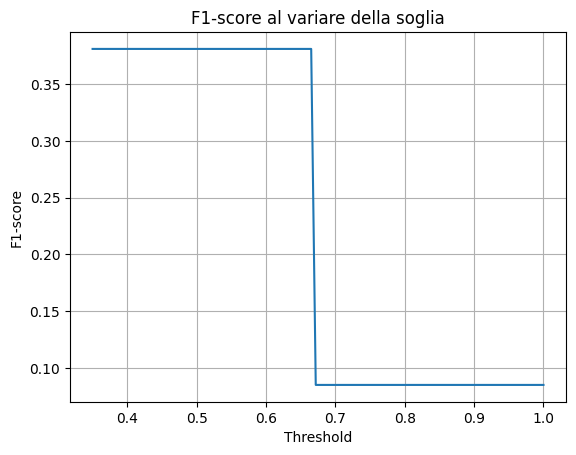

In [ ]:
# crea un oggetto StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0.35, 1, num=100)  # Array di soglie da 0 a 1


y_scores = cross_val_predict(estimator=best_estimator, X=X, y=y, cv=skf, method='predict_proba')[:, 1]  # Probabilità delle classi positive

threshold_best = 0
f1_value = 0
f1_scores = []
for threshold in thresholds:
    y_pred = apply_threshold(y_scores, threshold)  # Applicazione della soglia
    f1 = f1_score(y, y_pred)  # Calcolo dell'F1-score
    if (f1_value < f1 and threshold != 0 and threshold != 1):
      f1_value = f1
      threshold_best = threshold
    f1_scores.append(f1)

# Plot dell'F1-score al variare della soglia
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score al variare della soglia')
plt.grid(True)
plt.show()



In [ ]:
threshold_best

0.35

In [ ]:
#------------------------------------------#

#scores = cross_validate(best_estimator, X, y, cv=skf ,scoring='f1', return_train_score=True) # NON LA USO PERCHE' NON TROVO IL MODO PER MODIFICARE IL THRESHOLD
#print(scores['test_score'])


#------------------------------------------#

# cross_validate
f1_scores = []

# Esegui la cross-validation con la funzione cross_val_predict
for train_index, test_index in skf.split(X, y):
    X_train_, X_test_ = X.values[train_index], X.values[test_index]
    y_train_, y_test_ = y.values[train_index], y.values[test_index]

    # Addestra il modello sul training set
    best_estimator.fit(X_train_, y_train_)

    # Ottieni le probabilità predette
    y_scores_ = best_estimator.predict_proba(X_test_)[:, 1]

    # Applica il threshold alle previsioni
    y_pred = apply_threshold(y_scores_, threshold_best)

    # Calcola l'F1-score per il fold corrente
    f1_ = f1_score(y_test_, y_pred)

    # Aggiungi l'F1-score alla lista
    f1_scores.append(f1_)

# Stampa l'F1-score per ogni fold
print("F1-score per ogni fold:", f1_scores)



F1-score per ogni fold: [0.5, 0.26666666666666666, 0.4210526315789474, 0.35294117647058826, 0.35294117647058826]


In [ ]:
estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=feature_selection__k)), ('classifier', best_classifier)]
pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=5)),
                ('classifier', ExtraTreesClassifier())])

In [ ]:
threshold = f1_value
y_scores = pipe.predict_proba(X_test)[:, 1]  # Probabilità delle classi positive
y_pred = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.44      0.57        18
           1       0.33      0.71      0.45         7

    accuracy                           0.52        25
   macro avg       0.57      0.58      0.51        25
weighted avg       0.67      0.52      0.54        25



In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred)
print("Matrice di confusione:")
print(confusion_mat)

Matrice di confusione:
[[ 8 10]
 [ 2  5]]


#KNeighborsClassifier

In [ ]:
def param_grid(n_feature, lessDeep = False):
  k_ = []
  for i in range(1,n_feature+1,2):
    k_.append(i)

  if lessDeep == True :
    max_depth_ = 2
  else:
    max_depth_ = 4

  param_grid = [{
    'feature_selection__k': k_,
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}]

  # DecisionTreeClassifier(max_depth=max_depth_), RandomForestClassifier(max_depth=max_depth_),
  return param_grid

In [ ]:
#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed


In [ ]:
scoring = {
    'f1_score': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}



grid_search, best_estimator, total_time, y_pred = gridSearch(scoring, X, y)

# Salvare il modello migliore come file pickle
with open('/content/drive/MyDrive/dataset/best_model_f1_score1.pkl', 'wb') as file:
    pickle.dump(best_estimator, file)
# Caricare il modello salvato
with open('/content/drive/MyDrive/dataset/best_model_f1_score.pkl', 'rb') as file:
    best_estimator = pickle.load(file)
best_params = grid_search.best_params_

In [ ]:
best_params

{'classifier': KNeighborsClassifier(p=1),
 'classifier__n_neighbors': 5,
 'classifier__p': 1,
 'classifier__weights': 'uniform',
 'feature_selection__k': 19}

In [ ]:
# Estrazione del classificatore
best_classifier = best_params['classifier']
copy_best_param = best_params.copy()
del copy_best_param['classifier']

# Estrazione degli altri iperparametri
n_neighbors = best_params['classifier__n_neighbors']
weights = best_params['classifier__weights']
p = best_params['classifier__p']
feature_selection__k = best_params['feature_selection__k']


best_classifier = best_classifier.set_params(n_neighbors=n_neighbors, weights= weights, p=p)

In [ ]:
# Split del dataset in set di allenamento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

smote = SMOTE()

# Applicazione di SMOTE su X_train e y_train
X_train, y_train = smote.fit_resample(X_train, y_train)

# Verifica delle dimensioni dei set di allenamento e test
print("Dimensione di X_train:", X_train.shape)
print("Dimensione di X_test:", X_test.shape)
print("Dimensione di y_train:", y_train.shape)
print("Dimensione di y_test:", y_test.shape)

# Stampo quanti valori ho per ogni classe
print("Conteggio per ciascun valore in y:\n", count_per_value)

Dimensione di X_train: (130, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (130,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


In [ ]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

In [ ]:
# crea un oggetto StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0.35, 1, num=100)  # Array di soglie da 0 a 1


y_scores = cross_val_predict(estimator=best_estimator, X=X, y=y, cv=skf, method='predict_proba')[:, 1]  # Probabilità delle classi positive

threshold_best = 0
f1_value = 0
f1_scores = []
for threshold in thresholds:
    y_pred = apply_threshold(y_scores, threshold)  # Applicazione della soglia
    f1 = f1_score(y, y_pred)  # Calcolo dell'F1-score
    if (f1_value < f1 and threshold != 0 and threshold != 1):
      f1_value = f1
      threshold_best = threshold
    f1_scores.append(f1)

# Plot dell'F1-score al variare della soglia
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score al variare della soglia')
plt.grid(True)
plt.show()



In [ ]:
threshold_best

0.35

In [ ]:
#------------------------------------------#

#scores = cross_validate(best_estimator, X, y, cv=skf ,scoring='f1', return_train_score=True) # NON LA USO PERCHE' NON TROVO IL MODO PER MODIFICARE IL THRESHOLD
#print(scores['test_score'])


#------------------------------------------#

# cross_validate
f1_scores = []

# Esegui la cross-validation con la funzione cross_val_predict
for train_index, test_index in skf.split(X, y):
    X_train_, X_test_ = X.values[train_index], X.values[test_index]
    y_train_, y_test_ = y.values[train_index], y.values[test_index]

    # Addestra il modello sul training set
    best_estimator.fit(X_train_, y_train_)

    # Ottieni le probabilità predette
    y_scores_ = best_estimator.predict_proba(X_test_)[:, 1]

    # Applica il threshold alle previsioni
    y_pred = apply_threshold(y_scores_, threshold_best)

    # Calcola l'F1-score per il fold corrente
    f1_ = f1_score(y_test_, y_pred)

    # Aggiungi l'F1-score alla lista
    f1_scores.append(f1_)

# Stampa l'F1-score per ogni fold
print("F1-score per ogni fold:", f1_scores)



F1-score per ogni fold: [0.5, 0.26666666666666666, 0.4210526315789474, 0.35294117647058826, 0.35294117647058826]


In [ ]:
estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=feature_selection__k)), ('classifier', best_classifier)]
pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=19)),
                ('classifier', KNeighborsClassifier(p=1))])

In [ ]:
threshold = f1_value
y_scores = pipe.predict_proba(X_test)[:, 1]  # Probabilità delle classi positive
y_pred = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.17      0.27        18
           1       0.29      0.86      0.43         7

    accuracy                           0.36        25
   macro avg       0.52      0.51      0.35        25
weighted avg       0.62      0.36      0.32        25



In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred)
print("Matrice di confusione:")
print(confusion_mat)

Matrice di confusione:
[[ 3 15]
 [ 1  6]]


#SVC

In [ ]:
def param_grid(n_feature, lessDeep = False):
  k_ = []
  for i in range(1,n_feature+1,2):
    k_.append(i)

  if lessDeep == True :
    max_depth_ = 2
  else:
    max_depth_ = 4

  param_grid = [
    {
        'feature_selection__k': k_,
        'classifier': [SVC(kernel='linear',probability=True)],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'feature_selection__k': k_,
        'classifier': [SVC(kernel='rbf',probability=True)],
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': [0.1, 1, 10]
    }
]

  # DecisionTreeClassifier(max_depth=max_depth_), RandomForestClassifier(max_depth=max_depth_),
  return param_grid

In [ ]:
#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed


In [ ]:
scoring = {
    'f1_score': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}



grid_search, best_estimator, total_time, y_pred = gridSearch(scoring, X, y)

# Salvare il modello migliore come file pickle
with open('/content/drive/MyDrive/dataset/best_model_f1_score1.pkl', 'wb') as file:
    pickle.dump(best_estimator, file)
# Caricare il modello salvato
with open('/content/drive/MyDrive/dataset/best_model_f1_score.pkl', 'rb') as file:
    best_estimator = pickle.load(file)
best_params = grid_search.best_params_

In [ ]:
best_params

{'classifier': SVC(C=10, gamma=0.1, probability=True),
 'classifier__C': 10,
 'classifier__gamma': 0.1,
 'feature_selection__k': 15}

In [ ]:
# Estrazione del classificatore
best_classifier = best_params['classifier']
copy_best_param = best_params.copy()
del copy_best_param['classifier']

# Estrazione degli altri iperparametri
C = best_params['classifier__C']
gamma = best_params['classifier__gamma']
feature_selection__k = best_params['feature_selection__k']


best_classifier = best_classifier.set_params(C=C, gamma= gamma)


In [ ]:
# Split del dataset in set di allenamento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

smote = SMOTE()

# Applicazione di SMOTE su X_train e y_train
X_train, y_train = smote.fit_resample(X_train, y_train)

# Verifica delle dimensioni dei set di allenamento e test
print("Dimensione di X_train:", X_train.shape)
print("Dimensione di X_test:", X_test.shape)
print("Dimensione di y_train:", y_train.shape)
print("Dimensione di y_test:", y_test.shape)

# Stampo quanti valori ho per ogni classe
print("Conteggio per ciascun valore in y:\n", count_per_value)

Dimensione di X_train: (130, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (130,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


In [ ]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

In [ ]:
# crea un oggetto StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0.35, 1, num=100)  # Array di soglie da 0 a 1


y_scores = cross_val_predict(estimator=best_estimator, X=X, y=y, cv=skf, method='predict_proba')[:, 1]  # Probabilità delle classi positive

threshold_best = 0
f1_value = 0
f1_scores = []
for threshold in thresholds:
    y_pred = apply_threshold(y_scores, threshold)  # Applicazione della soglia
    f1 = f1_score(y, y_pred)  # Calcolo dell'F1-score
    if (f1_value < f1 and threshold != 0 and threshold != 1):
      f1_value = f1
      threshold_best = threshold
    f1_scores.append(f1)

# Plot dell'F1-score al variare della soglia
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score al variare della soglia')
plt.grid(True)
plt.show()



In [ ]:
threshold_best

0.35

In [ ]:
scores = cross_validate(best_estimator, X, y, cv=skf ,scoring='f1', return_train_score=True) # NON LA USO PERCHE' NON TROVO IL MODO PER MODIFICARE IL THRESHOLD
scores

{'fit_time': array([0.02836514, 0.01727128, 0.01450181, 0.0068593 , 0.00659966]),
 'score_time': array([0.10390329, 0.09274387, 0.03255129, 0.00567746, 0.0043118 ]),
 'test_score': array([0.5       , 0.26666667, 0.42105263, 0.35294118, 0.35294118]),
 'train_score': array([0.68852459, 0.75      , 0.6557377 , 0.57142857, 0.65454545])}

In [ ]:
#------------------------------------------#

#scores = cross_validate(best_estimator, X, y, cv=skf ,scoring='f1', return_train_score=True) # NON LA USO PERCHE' NON TROVO IL MODO PER MODIFICARE IL THRESHOLD
#print(scores['test_score'])


#------------------------------------------#
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross_validate
f1_scores = []

# Esegui la cross-validation con la funzione cross_val_predict
for train_index, test_index in skf.split(X, y):
    X_train_, X_test_ = X.values[train_index], X.values[test_index]
    y_train_, y_test_ = y.values[train_index], y.values[test_index]

    # Addestra il modello sul training set
    best_estimator.fit(X_train_, y_train_)

    # Ottieni le probabilità predette
    y_scores_ = best_estimator.predict_proba(X_test_)[:, 1]

    # Applica il threshold alle previsioni
    y_pred = apply_threshold(y_scores_, threshold_best)

    # Calcola l'F1-score per il fold corrente
    f1_ = f1_score(y_test_, y_pred)

    # Aggiungi l'F1-score alla lista
    f1_scores.append(f1_)

# Stampa l'F1-score per ogni fold
print("F1-score per ogni fold:", f1_scores)



F1-score per ogni fold: [0.5, 0.26666666666666666, 0.4210526315789474, 0.35294117647058826, 0.35294117647058826]


In [ ]:
estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=feature_selection__k)), ('classifier', best_classifier)]
pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=15)),
                ('classifier', SVC(C=10, gamma=0.1, probability=True))])

In [ ]:
threshold = f1_value
y_scores = pipe.predict_proba(X_test)[:, 1]  # Probabilità delle classi positive
y_pred = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.17      0.27        18
           1       0.29      0.86      0.43         7

    accuracy                           0.36        25
   macro avg       0.52      0.51      0.35        25
weighted avg       0.62      0.36      0.32        25



In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred)
print("Matrice di confusione:")
print(confusion_mat)

Matrice di confusione:
[[ 3 15]
 [ 1  6]]


#LogisticRegression

In [ ]:
def param_grid(n_feature, lessDeep = False):
  k_ = []
  for i in range(1,n_feature+1,2):
    k_.append(i)

  if lessDeep == True :
    max_depth_ = 2
  else:
    max_depth_ = 4

  param_grid = [
      {
          'feature_selection__k': k_,
          'classifier': [LogisticRegression()],
          'classifier__C': [0.1, 1, 10],
          'classifier__penalty': ['l1', 'l2'],
          'classifier__solver': ['liblinear', 'saga'],
          'classifier__max_iter': [100, 200, 500]
      }
  ]


  # DecisionTreeClassifier(max_depth=max_depth_), RandomForestClassifier(max_depth=max_depth_),
  return param_grid

In [ ]:
#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed


In [ ]:
scoring = {
    'f1_score': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}



grid_search, best_estimator, total_time, y_pred = gridSearch(scoring, X, y)

# Salvare il modello migliore come file pickle
with open('/content/drive/MyDrive/dataset/best_model_f1_score1.pkl', 'wb') as file:
    pickle.dump(best_estimator, file)
# Caricare il modello salvato
with open('/content/drive/MyDrive/dataset/best_model_f1_score.pkl', 'rb') as file:
    best_estimator = pickle.load(file)
best_params = grid_search.best_params_

In [ ]:
best_params

{'classifier': LogisticRegression(C=10, penalty='l1', solver='liblinear'),
 'classifier__C': 10,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear',
 'feature_selection__k': 45}

In [ ]:
# Estrazione del classificatore
best_classifier = best_params['classifier']
copy_best_param = best_params.copy()
del copy_best_param['classifier']

# Estrazione degli altri iperparametri
C = best_params['classifier__C']
max_iter = best_params['classifier__max_iter']
penalty = best_params['classifier__penalty']
solver = best_params['classifier__solver']

feature_selection__k = best_params['feature_selection__k']


best_classifier = best_classifier.set_params(C=C, max_iter= max_iter,penalty=penalty,solver=solver)

In [ ]:
# Split del dataset in set di allenamento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

smote = SMOTE()

# Applicazione di SMOTE su X_train e y_train
X_train, y_train = smote.fit_resample(X_train, y_train)

# Verifica delle dimensioni dei set di allenamento e test
print("Dimensione di X_train:", X_train.shape)
print("Dimensione di X_test:", X_test.shape)
print("Dimensione di y_train:", y_train.shape)
print("Dimensione di y_test:", y_test.shape)

# Stampo quanti valori ho per ogni classe
print("Conteggio per ciascun valore in y:\n", count_per_value)

Dimensione di X_train: (130, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (130,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


In [ ]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

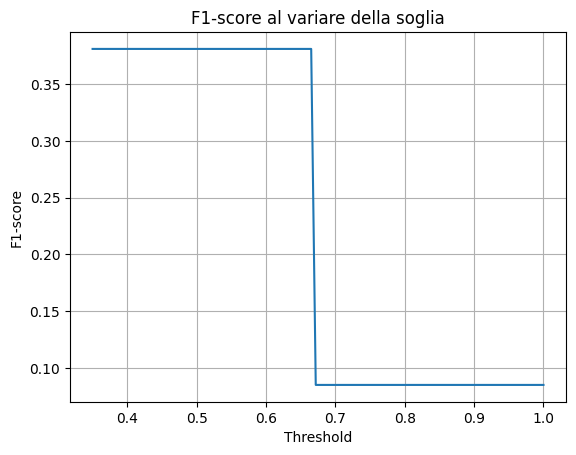

In [ ]:
# crea un oggetto StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0.35, 1, num=100)  # Array di soglie da 0 a 1


y_scores = cross_val_predict(estimator=best_estimator, X=X, y=y, cv=skf, method='predict_proba')[:, 1]  # Probabilità delle classi positive

threshold_best = 0
f1_value = 0
f1_scores = []
for threshold in thresholds:
    y_pred = apply_threshold(y_scores, threshold)  # Applicazione della soglia
    f1 = f1_score(y, y_pred)  # Calcolo dell'F1-score
    if (f1_value < f1 and threshold != 0 and threshold != 1):
      f1_value = f1
      threshold_best = threshold
    f1_scores.append(f1)

# Plot dell'F1-score al variare della soglia
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score al variare della soglia')
plt.grid(True)
plt.show()



In [ ]:
threshold_best

0.35

In [ ]:
#------------------------------------------#

#scores = cross_validate(best_estimator, X, y, cv=skf ,scoring='f1', return_train_score=True) # NON LA USO PERCHE' NON TROVO IL MODO PER MODIFICARE IL THRESHOLD
#print(scores['test_score'])


#------------------------------------------#

# cross_validate
f1_scores = []

# Esegui la cross-validation con la funzione cross_val_predict
for train_index, test_index in skf.split(X, y):
    X_train_, X_test_ = X.values[train_index], X.values[test_index]
    y_train_, y_test_ = y.values[train_index], y.values[test_index]

    # Addestra il modello sul training set
    best_estimator.fit(X_train_, y_train_)

    # Ottieni le probabilità predette
    y_scores_ = best_estimator.predict_proba(X_test_)[:, 1]

    # Applica il threshold alle previsioni
    y_pred = apply_threshold(y_scores_, threshold_best)

    # Calcola l'F1-score per il fold corrente
    f1_ = f1_score(y_test_, y_pred)

    # Aggiungi l'F1-score alla lista
    f1_scores.append(f1_)

# Stampa l'F1-score per ogni fold
print("F1-score per ogni fold:", f1_scores)



In [ ]:
estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=feature_selection__k)), ('classifier', best_classifier)]
pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=45)),
                ('classifier',
                 LogisticRegression(C=10, penalty='l1', solver='liblinear'))])

In [ ]:
threshold = f1_value
y_scores = pipe.predict_proba(X_test)[:, 1]  # Probabilità delle classi positive
y_pred = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.39      0.48        18
           1       0.21      0.43      0.29         7

    accuracy                           0.40        25
   macro avg       0.43      0.41      0.38        25
weighted avg       0.52      0.40      0.43        25



In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred)
print("Matrice di confusione:")
print(confusion_mat)

Matrice di confusione:
[[ 7 11]
 [ 4  3]]


# Set best parameters

In [30]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
threshold_best = 0.35


#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()
# Split del dataset in set di allenamento e test
X, X_TEST, y, y_TEST = train_test_split(X, y, test_size=0.2, stratify=y) #25 test

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y) #80 train 20 val

# smote = SMOTE()

# # Applicazione di SMOTE su X_train e y_train
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Verifica delle dimensioni dei set di allenamento e test
print("Dimensione di X_train:", X.shape)
print("Dimensione di X_test:", X_TEST.shape)
print("Dimensione di y_train:", y.shape)
print("Dimensione di y_test:", y_TEST.shape)

# Stampo quanti valori ho per ogni classe
print("Conteggio per ciascun valore in y:\n", count_per_value)

RandomForest = RandomForestClassifier(max_depth=10, n_estimators=200,min_samples_split= 2)
RFfeature_selection__k = 1

GradientBoosting = GradientBoostingClassifier(learning_rate=1, max_depth=None,n_estimators = 100)
GBfeature_selection__k = 11

svc = SVC(C=10, gamma=0.1, probability=True)
SVCfeature_selection__k= 15

ExtraTrees= ExtraTreesClassifier(max_depth = None,min_samples_split = 2,n_estimators = 100)
ETfeature_selection__k = 5

DecisionTree=DecisionTreeClassifier(min_samples_split=5,max_depth= None)
DTfeature_selection__k = 11

KNeighbors=KNeighborsClassifier(p=1,n_neighbors = 5,weights= 'uniform')
KNfeature_selection__k = 19

LogisticRegres = LogisticRegression(C=10, penalty='l1', solver='liblinear',max_iter =  100)
LRfeature_selection__k = 45

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed
Dimensione di X_train: (100, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (100,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


#Report Random Forest

In [17]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [34]:
RandomForest = RandomForestClassifier(max_depth=10, n_estimators=200,min_samples_split= 2)
RFfeature_selection__k = 1

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=RFfeature_selection__k)), ('classifier', RandomForest)]
RFpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
RFpipe, RFprob = prob_train(RFpipe, X, y)

Best threshold: 0.5963333333333334


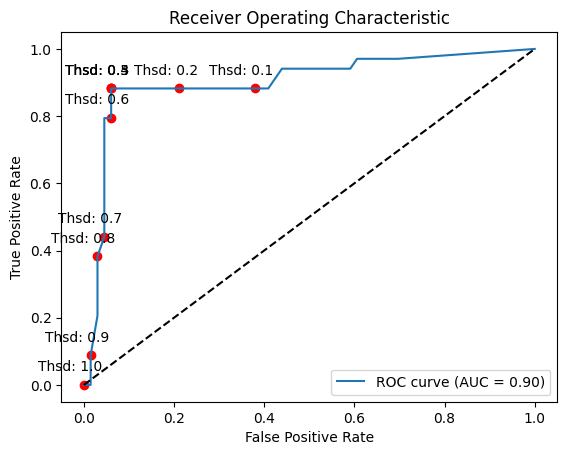

In [50]:
best_threshold = plot_ROC(y, RFprob)

In [51]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
train_class = apply_threshold(RFprob, best_threshold)

print(classification_report(y,train_class))

confusion_mat = confusion_matrix(y,train_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        66
           1       0.88      0.88      0.88        34

    accuracy                           0.92       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.92      0.92      0.92       100

Matrice di confusione:
[[62  4]
 [ 4 30]]


In [48]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

y_pred = RFpipe.predict(X_TEST)

test_class = apply_threshold(y_pred, best_threshold)

print(classification_report(y_TEST,test_class))

confusion_mat = confusion_matrix(y_TEST,test_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.65      0.65      0.65        17
           1       0.25      0.25      0.25         8

    accuracy                           0.52        25
   macro avg       0.45      0.45      0.45        25
weighted avg       0.52      0.52      0.52        25

Matrice di confusione:
[[11  6]
 [ 6  2]]


In [27]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [53]:
selected_column_df = pd.DataFrame(X["gamma_mean_4"])


In [54]:
RandomForest = RandomForestClassifier(max_depth=2, n_estimators=200,min_samples_split= 2)
RFfeature_selection__k = 1

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=RFfeature_selection__k)), ('classifier', RandomForest)]
RFpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
RFpipe, RFprob = prob_train(RFpipe, selected_column_df, y)

Best threshold: 0.3292986027196792


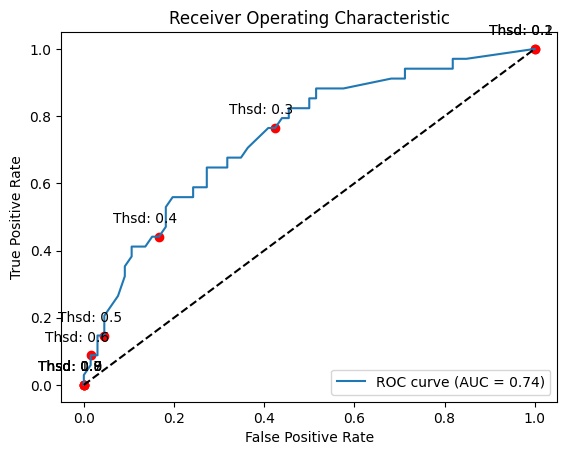

In [55]:
best_threshold = plot_ROC(y, RFprob)

In [56]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
train_class = apply_threshold(RFprob, best_threshold)

print(classification_report(y,train_class))

confusion_mat = confusion_matrix(y,train_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        66
           1       0.55      0.65      0.59        34

    accuracy                           0.70       100
   macro avg       0.68      0.69      0.68       100
weighted avg       0.71      0.70      0.71       100

Matrice di confusione:
[[48 18]
 [12 22]]


In [57]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

# Estrai la colonna corrispondente all'indice selected_feature_index
selected_column_df = pd.DataFrame(X_TEST["gamma_mean_4"])
y_pred = RFpipe.predict(selected_column_df)

test_class = apply_threshold(y_pred, best_threshold)

print(classification_report(y_TEST,test_class))

confusion_mat = confusion_matrix(y_TEST,test_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.25      0.12      0.17         8

    accuracy                           0.60        25
   macro avg       0.46      0.47      0.45        25
weighted avg       0.53      0.60      0.55        25

Matrice di confusione:
[[14  3]
 [ 7  1]]


#Report Gradient Boosting

In [52]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0


  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [53]:
GradientBoosting = GradientBoostingClassifier(learning_rate=0.2, max_depth=None,n_estimators = 100)
GBfeature_selection__k = 11
estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=GBfeature_selection__k)), ('classifier', GradientBoosting)]
GBpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
GBpipe, GBprob = prob_train(GBpipe, X, y)

Best threshold: 0.9999999652453043


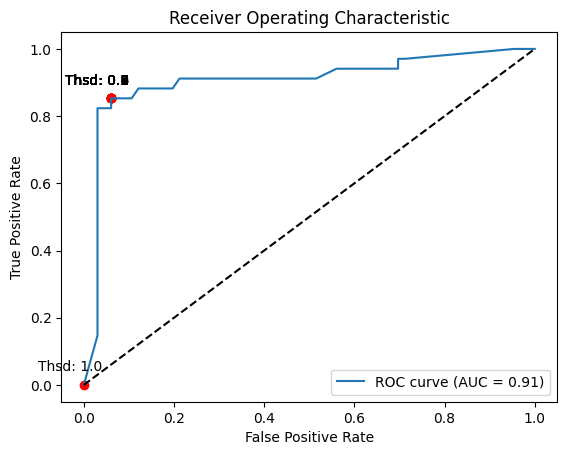

In [55]:
best_threshold = plot_ROC(y, GBprob)

Train report

In [56]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
train_class = apply_threshold(GBprob, best_threshold)

print(classification_report(y,train_class))

confusion_mat = confusion_matrix(y,train_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        66
           1       0.93      0.82      0.87        34

    accuracy                           0.92       100
   macro avg       0.92      0.90      0.91       100
weighted avg       0.92      0.92      0.92       100

Matrice di confusione:
[[64  2]
 [ 6 28]]


Test report

In [58]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

y_pred = GBpipe.predict(X_TEST)

test_class = apply_threshold(y_pred, best_threshold)

print(classification_report(y_TEST,test_class))

confusion_mat = confusion_matrix(y_TEST,test_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.62      0.47      0.53        17
           1       0.25      0.38      0.30         8

    accuracy                           0.44        25
   macro avg       0.43      0.42      0.42        25
weighted avg       0.50      0.44      0.46        25

Matrice di confusione:
[[8 9]
 [5 3]]


#Report SVC

In [61]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [62]:
svc = SVC(C=10, gamma=0.1, probability=True)
SVCfeature_selection__k= 15

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=SVCfeature_selection__k)), ('classifier', svc)]
SVCpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
SVCpipe, SVCprob = prob_train(SVCpipe, X, y)

Best threshold: 0.46998930508540626


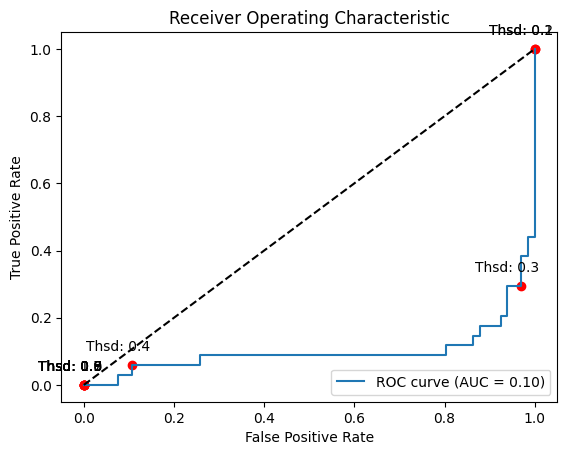

In [69]:
best_threshold = plot_ROC(y, SVCprob)

Train report

In [71]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
train_class = apply_threshold(SVCprob, best_threshold)

print(classification_report(y,train_class))

confusion_mat = confusion_matrix(y,train_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.66      0.98      0.79        66
           1       0.00      0.00      0.00        34

    accuracy                           0.65       100
   macro avg       0.33      0.49      0.39       100
weighted avg       0.43      0.65      0.52       100

Matrice di confusione:
[[65  1]
 [34  0]]


Test report

In [ ]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

y_pred = SVCpipe.predict(X_TEST)

test_class = apply_threshold(y_pred, 0.35)

print(classification_report(y_TEST,test_class))

confusion_mat = confusion_matrix(y_TEST,test_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.65      0.76      0.70        17
           1       0.20      0.12      0.15         8

    accuracy                           0.56        25
   macro avg       0.43      0.44      0.43        25
weighted avg       0.51      0.56      0.53        25

Matrice di confusione:
[[13  4]
 [ 7  1]]


#Report Extra Trees

In [72]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [73]:
ExtraTrees= ExtraTreesClassifier(max_depth = None,min_samples_split = 2,n_estimators = 100)
ETfeature_selection__k = 5

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=ETfeature_selection__k)), ('classifier', ExtraTrees)]
ETpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
ETpipe, ETprob = prob_train(ETpipe, X, y)

Best threshold: 0.22


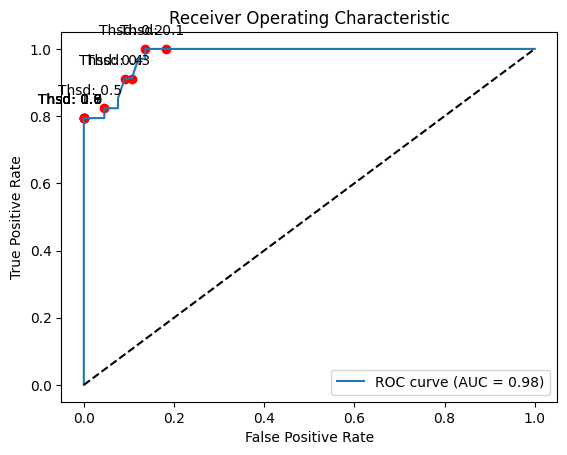

In [74]:
best_threshold = plot_ROC(y, ETprob)

Train report

In [75]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
train_class = apply_threshold(ETprob, best_threshold)

print(classification_report(y,train_class))

confusion_mat = confusion_matrix(y,train_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        66
           1       0.79      1.00      0.88        34

    accuracy                           0.91       100
   macro avg       0.90      0.93      0.90       100
weighted avg       0.93      0.91      0.91       100

Matrice di confusione:
[[57  9]
 [ 0 34]]


Test report

In [76]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

y_pred = ETpipe.predict(X_TEST)

test_class = apply_threshold(y_pred, best_threshold)

print(classification_report(y_TEST,test_class))

confusion_mat = confusion_matrix(y_TEST,test_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.65      0.76      0.70        17
           1       0.20      0.12      0.15         8

    accuracy                           0.56        25
   macro avg       0.43      0.44      0.43        25
weighted avg       0.51      0.56      0.53        25

Matrice di confusione:
[[13  4]
 [ 7  1]]


#Report Decision Tree

In [77]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [78]:
DecisionTree=DecisionTreeClassifier(min_samples_split=5,max_depth= None)
DTfeature_selection__k = 11

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=DTfeature_selection__k)), ('classifier', DecisionTree)]
DTpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
DTpipe, DTprob = prob_train(DTpipe, X, y)

Best threshold: 0.5


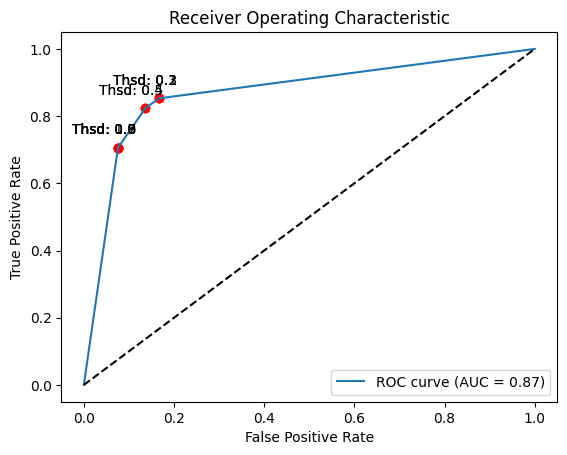

In [79]:
best_threshold = plot_ROC(y, DTprob)

Train report

In [80]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
train_class = apply_threshold(DTprob, best_threshold)

print(classification_report(y,train_class))

confusion_mat = confusion_matrix(y,train_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        66
           1       0.76      0.82      0.79        34

    accuracy                           0.85       100
   macro avg       0.83      0.84      0.84       100
weighted avg       0.85      0.85      0.85       100

Matrice di confusione:
[[57  9]
 [ 6 28]]


Test report

In [81]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

y_pred = DTpipe.predict(X_TEST)

test_class = apply_threshold(y_pred, best_threshold)

print(classification_report(y_TEST,test_class))

confusion_mat = confusion_matrix(y_TEST,test_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.67      0.47      0.55        17
           1       0.31      0.50      0.38         8

    accuracy                           0.48        25
   macro avg       0.49      0.49      0.47        25
weighted avg       0.55      0.48      0.50        25

Matrice di confusione:
[[8 9]
 [4 4]]


#Report KNeighbors

In [82]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [83]:
KNeighbors=KNeighborsClassifier(p=1,n_neighbors = 5,weights= 'uniform')
KNfeature_selection__k = 19

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=KNfeature_selection__k)), ('classifier', KNeighbors)]
KNpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
KNpipe, KNprob = prob_train(KNpipe, X, y)

Best threshold: 0.6


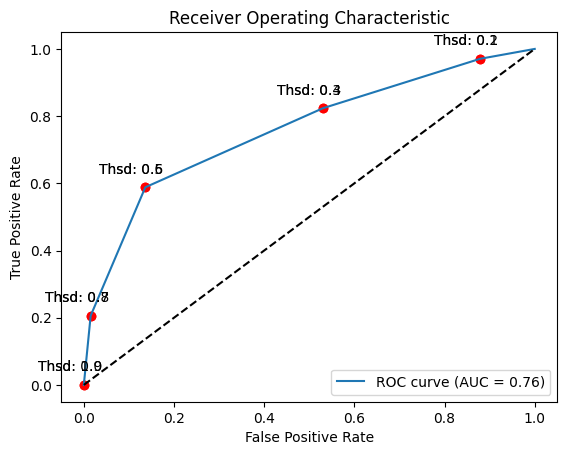

In [84]:
best_threshold = plot_ROC(y, KNprob)

Train report

In [86]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
train_class = apply_threshold(KNprob, best_threshold)

print(classification_report(y,train_class))

confusion_mat = confusion_matrix(y,train_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        66
           1       0.69      0.59      0.63        34

    accuracy                           0.77       100
   macro avg       0.75      0.73      0.73       100
weighted avg       0.76      0.77      0.77       100

Matrice di confusione:
[[57  9]
 [14 20]]


Test report

In [87]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

y_pred = KNpipe.predict(X_TEST)

test_class = apply_threshold(y_pred, best_threshold)

print(classification_report(y_TEST,test_class))

confusion_mat = confusion_matrix(y_TEST,test_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.50      0.50      0.50         8

    accuracy                           0.68        25
   macro avg       0.63      0.63      0.63        25
weighted avg       0.68      0.68      0.68        25

Matrice di confusione:
[[13  4]
 [ 4  4]]


#Report Logistic Regression

In [88]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [109]:
LogisticRegres = LogisticRegression(C=10, penalty='l1', solver='liblinear',max_iter =  100)
LRfeature_selection__k = 45

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=LRfeature_selection__k)), ('classifier', LogisticRegres)]
LRpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
LRpipe, LRprob = prob_train(LRpipe, X, y)

Best threshold: 0.4149873863140597


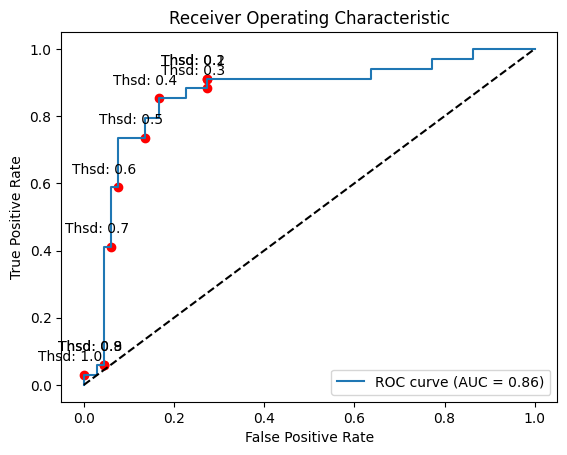

In [92]:
best_threshold = plot_ROC(y, LRprob)

Train report

In [110]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
train_class = apply_threshold(LRprob, best_threshold)

print(classification_report(y,train_class))

confusion_mat = confusion_matrix(y,train_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        66
           1       0.69      0.59      0.63        34

    accuracy                           0.77       100
   macro avg       0.75      0.73      0.73       100
weighted avg       0.76      0.77      0.77       100

Matrice di confusione:
[[57  9]
 [14 20]]


Test report

In [111]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)

y_pred = LRpipe.predict(X_TEST)

test_class = apply_threshold(y_pred, best_threshold)

print(classification_report(y_TEST,test_class))

confusion_mat = confusion_matrix(y_TEST,test_class)
print("Matrice di confusione:")
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.50      0.50      0.50         8

    accuracy                           0.68        25
   macro avg       0.63      0.63      0.63        25
weighted avg       0.68      0.68      0.68        25

Matrice di confusione:
[[13  4]
 [ 4  4]]


#Ensemble x = 1 : xi E [-1 1] with combination and with overffitting models

In [15]:
def prob_train(pipe, X, y):
  best_model = None
  best_score = 0
  best_proba = 0

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipe.fit(X_train, y_train)
      y_pred = pipe.predict(X_train)
      score = f1_score(y_train, y_pred)

      if score > best_score:
          best_model = pipe
          best_score = score

  best_proba = best_model.predict_proba(X)[:, 1]

  return best_model, best_proba

In [16]:
def apply_threshold(y_scores, threshold):
    return (y_scores >= threshold).astype(int)
threshold_best = 0.35


#estraggo il dataset
np.random.seed(35)
df = pd.read_csv(file_path)
df_shape = df.shape

#trovo le correlazioni, mostro le correlazioni e le elimino
features_to_remove, correlation_dict_all = correlation_feature(df, df.shape[1], 0.8,subplot=False, noPlot = 1)
print_correlation(correlation_dict_all)
df = delete_correlation(features_to_remove)
df.shape

#splitto il dataset in feature e target
X = df.drop('target', axis=1)
df['target'] = df['target'].apply(lambda x: 1 if x in ['emotion', 'beautiful'] else 0)
y = df['target']
# Conta il numero di elementi per ciascun valore presente in y
count_per_value = y.value_counts()
# Split del dataset in set di allenamento e test
X, X_TEST, y, y_TEST = train_test_split(X, y, test_size=0.2, stratify=y) #25 test

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y) #80 train 20 val

# smote = SMOTE()

# # Applicazione di SMOTE su X_train e y_train
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Verifica delle dimensioni dei set di allenamento e test
print("Dimensione di X_train:", X.shape)
print("Dimensione di X_test:", X_TEST.shape)
print("Dimensione di y_train:", y.shape)
print("Dimensione di y_test:", y_TEST.shape)

# Stampo quanti valori ho per ogni classe
print("Conteggio per ciascun valore in y:\n", count_per_value)

RandomForest = RandomForestClassifier(max_depth=10, n_estimators=200,min_samples_split= 2)
RFfeature_selection__k = 1

GradientBoosting = GradientBoostingClassifier(learning_rate=1, max_depth=None,n_estimators = 100)
GBfeature_selection__k = 11

svc = SVC(C=10, gamma=0.1, probability=True)
SVCfeature_selection__k= 15

ExtraTrees= ExtraTreesClassifier(max_depth = None,min_samples_split = 2,n_estimators = 100)
ETfeature_selection__k = 5

DecisionTree=DecisionTreeClassifier(min_samples_split=5,max_depth= None)
DTfeature_selection__k = 11

KNeighbors=KNeighborsClassifier(p=1,n_neighbors = 5,weights= 'uniform')
KNfeature_selection__k = 19

LogisticRegres = LogisticRegression(C=10, penalty='l1', solver='liblinear',max_iter =  100)
LRfeature_selection__k = 45

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=RFfeature_selection__k)), ('classifier', RandomForest)]
RFpipe = Pipeline(estimators)
#RFpipe.fit(X_train, y_train)
RFpipe, RFprob = prob_train(RFpipe, X, y)


estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=GBfeature_selection__k)), ('classifier', GradientBoosting)]
GBpipe = Pipeline(estimators)
GBpipe, GBprob = prob_train(GBpipe, X, y)

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=SVCfeature_selection__k)), ('classifier', svc)]
SVCpipe = Pipeline(estimators)
SVCpipe, SVCprob = prob_train(SVCpipe, X, y)

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=ETfeature_selection__k)), ('classifier', ExtraTrees)]
ETpipe = Pipeline(estimators)
ETpipe, ETprob = prob_train(ETpipe, X, y)

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=DTfeature_selection__k)), ('classifier', DecisionTree)]
DTpipe = Pipeline(estimators)
DTpipe, DTprob = prob_train(DTpipe, X, y)

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=KNfeature_selection__k)), ('classifier', KNeighbors)]
KNpipe = Pipeline(estimators)
KNpipe, KNprob = prob_train(KNpipe, X, y)

estimators = [('scaler', StandardScaler()), ('feature_selection', SelectKBest(k=LRfeature_selection__k)), ('classifier', LogisticRegres)]
LRpipe = Pipeline(estimators)
LRpipe, LRprob = prob_train(LRpipe, X, y)





# print("------------RF---------------------")
# y_predRF = RFpipe.predict_proba(X_val)[:, 1]  # Probabilità delle classi positive
# #y_predRF = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
# #print(classification_report(y_test,y_predRF))

# # confusion_mat = confusion_matrix(y_test, y_predRF)
# # print("Matrice di confusione:")
# # print(confusion_mat)

# print("------------GB---------------------")
# y_predGB = GBpipe.predict_proba(X_val)[:, 1]  # Probabilità delle classi positive
# #y_predGB = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
# #print(classification_report(y_test,y_predGB))

# # confusion_mat = confusion_matrix(y_test, y_predGB)
# # print("Matrice di confusione:")
# # print(confusion_mat)
# print("------------SVC---------------------")
# y_predSVC = SVCpipe.predict_proba(X_val)[:, 1]  # Probabilità delle classi positive
# #y_predSVC = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
# #print(classification_report(y_test,y_predSVC))

# # confusion_mat = confusion_matrix(y_test, y_predSVC)
# # print("Matrice di confusione:")
# # print(confusion_mat)
# print("------------ET---------------------")
# y_predET = ETpipe.predict_proba(X_val)[:, 1]  # Probabilità delle classi positive
# #y_predET = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
# #print(classification_report(y_test,y_predET))

# # confusion_mat = confusion_matrix(y_test, y_predET)
# # print("Matrice di confusione:")
# # print(confusion_mat)

# print("-------Decision Tree---------------------")
# y_predDT = DTpipe.predict_proba(X_val)[:, 1]

# print("---------KN----------------")

# y_predKN = KNpipe.predict_proba(X_val)[:, 1]  # Probabilità delle classi positive

# print("---------Logistic Regression----------------")

# y_predLR = LRpipe.predict_proba(X_val)[:, 1]


For electroid 1, 38/50 -> 0.76 values have been removed
For electroid 2, 40/50 -> 0.8 values have been removed
For electroid 3, 48/50 -> 0.96 values have been removed
For electroid 4, 42/50 -> 0.84 values have been removed
For electroid 5, 42/50 -> 0.84 values have been removed
For electroid 6, 48/50 -> 0.96 values have been removed
For electroid 7, 41/50 -> 0.82 values have been removed
For electroid 8, 43/50 -> 0.86 values have been removed
Dimensione di X_train: (100, 58)
Dimensione di X_test: (25, 58)
Dimensione di y_train: (100,)
Dimensione di y_test: (25,)
Conteggio per ciascun valore in y:
 0    83
1    42
Name: target, dtype: int64


In [ ]:
# import numpy as np
# from sklearn.metrics import f1_score
# from scipy.optimize import minimize
# threshold_best = 0
# f1_best = 0
# x_best = 0
# # Definisci la funzione obiettivo da massimizzare (F1-score)
# def objective(x, A, c):
#     y_predict = np.dot(A, x)
#     global threshold_best, f1_best,x_best

#     for threshold in range(0, 11, 1):
#       threshold = threshold / 10.0
#       y_predict_binary = (y_predict > threshold).astype(int)
#       if f1_best < f1_score(c, y_predict_binary):
#         f1_best = f1_score(c, y_predict_binary)
#         threshold_best = threshold
#         x_best = x
#     return -f1_best

# # Definisci il vincolo di somma(x) = 1
# def constraint(x):
#     return np.sum(x) - 1

# # Definisci la matrice A (n * 4) e il vettore c (n,)
# A = np.array([y_predET.tolist(),
#               y_predSVC.tolist(),
#               y_predRF.tolist(),
#               y_predGB.tolist(),
#               y_predDT.tolist(),
#               y_predKN.tolist(),
#               y_predLR.tolist()])

# A = np.transpose(A)
# c = np.array(y_val)

# # Parametri dell'ottimizzazione multi-start
# num_starts = 3000  # Numero di tentativi
# best_f1 = -1     # Inizializza il miglior F1-score a un valore negativo
# best_x = None    # Inizializza i pesi migliori a None


# # Esegui l'ottimizzazione multi-start
# for _ in range(num_starts):
#     # Inizializza i pesi x (dimensione 4) inizialmente a valori casuali
#     x0 = np.random.random(7)

#     # Definisci il problema di ottimizzazione
#     problem = {'type': 'eq', 'fun': constraint}

#     # Risolvi il problema di ottimizzazione per massimizzare l'F1-score
#     solution = minimize(objective, x0, args=(A, c), constraints=problem)

#     # Ottieni i pesi ottimali e l'F1-score corrispondente
#     x_optimal = solution.x
#     f1_optimal = -solution.fun

#     # Aggiorna i pesi e l'F1-score migliori se necessario
#     if f1_optimal > best_f1:
#         best_f1 = f1_optimal
#         best_x = x_optimal

# # Calcola l'F1-score utilizzando i pesi migliori
# y_predict_optimal = np.dot(A, best_x)
# y_predict_optimal_binary = (y_predict_optimal > 0.5).astype(int)
# f1_optimal = f1_score(c, y_predict_optimal_binary)




In [ ]:
from itertools import combinations
from tqdm import tqdm



threshold_best = 0
f1_best = 0
x_best = 0
# Definisci la funzione obiettivo da massimizzare (F1-score)
def objective(x, A, c):
    y_predict = np.dot(A, x)
    global threshold_best, f1_best,x_best

    for threshold in range(0, 11, 1):
      threshold = threshold / 10.0
      y_predict_binary = (y_predict > threshold).astype(int)
      if f1_best < f1_score(c, y_predict_binary):
        f1_best = f1_score(c, y_predict_binary)
        threshold_best = threshold
        x_best = x
    return -f1_best

# Definisci il vincolo di somma(x) = 1
def constraint(x):
    return np.sum(x) - 1


def create_row_combinations(matrix):
    combinations_list = []
    index_combinations_list = []
    num_rows = len(matrix)
    row_indices = list(range(num_rows))

    for r in range(1, num_rows + 1):
        row_combinations = combinations(matrix, r)
        index_combinations = combinations(row_indices, r)
        combinations_list.extend(row_combinations)
        index_combinations_list.extend(index_combinations)

    return combinations_list, index_combinations_list
# Creazione delle liste delle probabilità
RFprob_list = RFprob.tolist()
GBprob_list = GBprob.tolist()
SVCprob_list = SVCprob.tolist()
ETprob_list = ETprob.tolist()
DTprob_list = DTprob.tolist()
KNprob_list = KNprob.tolist()
LRprob_list = LRprob.tolist()

# Creazione della matrice
A = np.array([RFprob_list, GBprob_list, SVCprob_list, ETprob_list, DTprob_list, KNprob_list, LRprob_list])

combinations, index_combinations_list = create_row_combinations(A)

# Parametri dell'ottimizzazione multi-start
num_starts = 100  # Numero di tentativi
best_f1 = -1     # Inizializza il miglior F1-score a un valore negativo
best_x = None    # Inizializza i pesi migliori a None


best_matrix = A
index_best_matrix = 0
f1_best = 0
threshold_best = 0
x_best = 0


for l, A_combination in tqdm(enumerate(combinations)):
  c = y
  A = np.transpose(A_combination)
  # Risolvi il sistema di equazioni lineari A * x = c
  x, residuals, rank, singular_values = np.linalg.lstsq(A, c, rcond=None)


  for _ in range(num_starts):
    # Inizializza i pesi x (dimensione 4) inizialmente a valori casuali
    x0 = np.random.random(len(index_combinations_list[l]))
    x0 = x0 / np.sum(x0)

    # Definisci il problema di ottimizzazione
    problem = {'type': 'eq', 'fun': constraint}

    # Risolvi il problema di ottimizzazione per massimizzare l'F1-score
    solution = minimize(objective, x0, args=(A, c), constraints=problem)

    # Ottieni i pesi ottimali e l'F1-score corrispondente
    x_optimal = solution.x
    f1_optimal = -solution.fun

    # Aggiorna i pesi e l'F1-score migliori se necessario
    if f1_optimal > best_f1:
        best_f1 = f1_optimal
        best_x = x_optimal
        best_matrix = A
        index_best_matrix = index_combinations_list[l]


c_pred_ = np.dot(best_matrix,x_best)
c_pred = (c_pred_ > threshold_best).astype(int)


In [ ]:

print("classi reali:", np.array(c))
print("vs")
print("classi predette:" ,c_pred)
print("soglia",threshold_best)
print("f1_score",f1_best)
print("best_x",best_x)
print("index_best_matrix", index_best_matrix)
print(classification_report(c,c_pred))

confusion_mat = confusion_matrix(c, c_pred)
print("Matrice di confusione:")
print(confusion_mat)




classi reali: [0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0
 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1]
vs
classi predette: [0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0
 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1]
soglia 0.5
f1_score 0.9253731343283583
best_x [0.17670406 0.33058137 0.49271457]
index_best_matrix (2, 3, 5)
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.94      0.91      0.93        34

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.95      0.95       100

Matrice di confusione:
[[64  2]
 [ 3 31]]


In [ ]:

print("------------RF---------------------")
y_predRF = RFpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive
#y_predRF = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
#print(classification_report(y_test,y_predRF))

# confusion_mat = confusion_matrix(y_test, y_predRF)
# print("Matrice di confusione:")
# print(confusion_mat)

print("------------GB---------------------")
y_predGB = GBpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive
#y_predGB = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
#print(classification_report(y_test,y_predGB))

# confusion_mat = confusion_matrix(y_test, y_predGB)
# print("Matrice di confusione:")
# print(confusion_mat)
print("------------SVC---------------------")
y_predSVC = SVCpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive
#y_predSVC = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
#print(classification_report(y_test,y_predSVC))

# confusion_mat = confusion_matrix(y_test, y_predSVC)
# print("Matrice di confusione:")
# print(confusion_mat)
print("------------ET---------------------")
y_predET = ETpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive
#y_predET = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
#print(classification_report(y_test,y_predET))

# confusion_mat = confusion_matrix(y_test, y_predET)
# print("Matrice di confusione:")
# print(confusion_mat)

print("-------Decision Tree---------------------")
y_predDT = DTpipe.predict_proba(X_TEST)[:, 1]

print("---------KN----------------")

y_predKN = KNpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive

print("---------Logistic Regression----------------")

y_predLR = LRpipe.predict_proba(X_TEST)[:, 1]


------------RF---------------------
------------GB---------------------
------------SVC---------------------
------------ET---------------------
-------Decision Tree---------------------
---------KN----------------
---------Logistic Regression----------------


In [ ]:
A = np.array([y_predET.tolist(),
              y_predSVC.tolist(),
              y_predRF.tolist(),
              y_predGB.tolist(),
              y_predDT.tolist(),
              y_predKN.tolist(),
              y_predLR.tolist()])

selected_A = A[[index_best_matrix]]

A = np.transpose(selected_A)

c= np.dot(A, x_best)
c = (c > threshold_best).astype(int)
y_pred = c
print("valori reali",np.array(y_TEST))
print("valori predetti", y_pred)
print(classification_report(y_TEST,y_pred))

confusion_mat = confusion_matrix(y_TEST, y_pred)
print("Matrice di confusione:")
print(confusion_mat)

valori reali [0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1]
valori predetti [1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1]
              precision    recall  f1-score   support

           0       0.62      0.47      0.53        17
           1       0.25      0.38      0.30         8

    accuracy                           0.44        25
   macro avg       0.43      0.42      0.42        25
weighted avg       0.50      0.44      0.46        25

Matrice di confusione:
[[8 9]
 [5 3]]


<ipython-input-63-abcd4cf6aead>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selected_A = A[[index_best_matrix]]


#Ensemble x = 1 : xi E [-1 1] without overfitting model

100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


Best threshold: 0.300316868307016


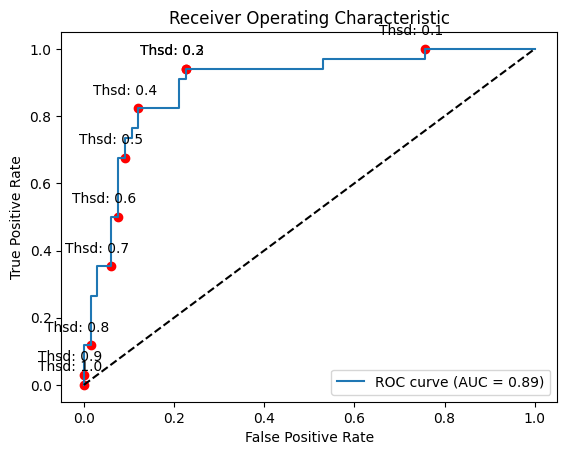

In [17]:



threshold_best = 0
f1_best = 0
x_best = 0
# Definisci la funzione obiettivo da massimizzare (F1-score)
def objective(x, A, c):
    y_predict = np.dot(A, x)
    global threshold_best, f1_best,x_best

    for threshold in range(0, 11, 1):
      threshold = threshold / 10.0
      y_predict_binary = (y_predict > threshold).astype(int)
      if f1_best < f1_score(c, y_predict_binary):
        f1_best = f1_score(c, y_predict_binary)
        threshold_best = threshold
        x_best = x
    return -f1_best

# Definisci il vincolo di somma(x) = 1
def constraint(x):
    return np.sum(x) - 1



# Creazione delle liste delle probabilità
# RFprob_list = RFprob.tolist()
# GBprob_list = GBprob.tolist()
# SVCprob_list = SVCprob.tolist()
# ETprob_list = ETprob.tolist()
# DTprob_list = DTprob.tolist()
KNprob_list = KNprob.tolist()
LRprob_list = LRprob.tolist()

# Creazione della matrice
#A = np.array([RFprob_list, GBprob_list, SVCprob_list, ETprob_list, DTprob_list, KNprob_list, LRprob_list])
A = np.array([ KNprob_list, LRprob_list])


# Parametri dell'ottimizzazione multi-start
num_starts = 100  # Numero di tentativi
best_f1 = -1     # Inizializza il miglior F1-score a un valore negativo
best_x = None    # Inizializza i pesi migliori a None


best_matrix = A
index_best_matrix = 0
f1_best = 0
threshold_best = 0
x_best = 0



c = y
A = np.transpose(A)
# Risolvi il sistema di equazioni lineari A * x = c
x, residuals, rank, singular_values = np.linalg.lstsq(A, c, rcond=None)


for _ in tqdm(range(num_starts)):
  # Inizializza i pesi x (dimensione 4) inizialmente a valori casuali
  x0 = np.random.random(2)
  x0 = x0 / np.sum(x0)

  # Definisci il problema di ottimizzazione
  problem = {'type': 'eq', 'fun': constraint}

  # Risolvi il problema di ottimizzazione per massimizzare l'F1-score
  solution = minimize(objective, x0, args=(A, c), constraints=problem)

  # Ottieni i pesi ottimali e l'F1-score corrispondente
  x_optimal = solution.x
  f1_optimal = -solution.fun

  # Aggiorna i pesi e l'F1-score migliori se necessario
  if f1_optimal > best_f1:
      best_f1 = f1_optimal
      best_x = x_optimal
      best_matrix = A


c_pred_ = np.dot(best_matrix,x_best)
best_threshold = plot_ROC(c, c_pred_)
c_pred = (c_pred_ > threshold_best).astype(int)


In [19]:

print("classi reali:", np.array(c))
print("vs")
print("classi predette:" ,c_pred)
print("soglia",threshold_best)
print("f1_score",f1_best)
print("best_x",best_x)
print("index_best_matrix", index_best_matrix)
print(classification_report(c,c_pred))

confusion_mat = confusion_matrix(c, c_pred)
print("Matrice di confusione:")
print(confusion_mat)




classi reali: [0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0
 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1]
vs
classi predette: [1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0
 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1]
soglia 0.3
f1_score 0.7901234567901235
best_x [0.41065242 0.58934758]
index_best_matrix 0
              precision    recall  f1-score   support

           0       0.96      0.77      0.86        66
           1       0.68      0.94      0.79        34

    accuracy                           0.83       100
   macro avg       0.82      0.86      0.82       100
weighted avg       0.87      0.83      0.83       100

Matrice di confusione:
[[51 15]
 [ 2 32]]


In [20]:

print("------------RF---------------------")
y_predRF = RFpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive
#y_predRF = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
#print(classification_report(y_test,y_predRF))

# confusion_mat = confusion_matrix(y_test, y_predRF)
# print("Matrice di confusione:")
# print(confusion_mat)

print("------------GB---------------------")
y_predGB = GBpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive
#y_predGB = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
#print(classification_report(y_test,y_predGB))

# confusion_mat = confusion_matrix(y_test, y_predGB)
# print("Matrice di confusione:")
# print(confusion_mat)
print("------------SVC---------------------")
y_predSVC = SVCpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive
#y_predSVC = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
#print(classification_report(y_test,y_predSVC))

# confusion_mat = confusion_matrix(y_test, y_predSVC)
# print("Matrice di confusione:")
# print(confusion_mat)
print("------------ET---------------------")
y_predET = ETpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive
#y_predET = apply_threshold(y_scores, threshold_best)  # Applicazione della soglia
#print(classification_report(y_test,y_predET))

# confusion_mat = confusion_matrix(y_test, y_predET)
# print("Matrice di confusione:")
# print(confusion_mat)

print("-------Decision Tree---------------------")
y_predDT = DTpipe.predict_proba(X_TEST)[:, 1]

print("---------KN----------------")

y_predKN = KNpipe.predict_proba(X_TEST)[:, 1]  # Probabilità delle classi positive

print("---------Logistic Regression----------------")

y_predLR = LRpipe.predict_proba(X_TEST)[:, 1]


------------RF---------------------
------------GB---------------------
------------SVC---------------------
------------ET---------------------
-------Decision Tree---------------------
---------KN----------------
---------Logistic Regression----------------


In [21]:
# A = np.array([y_predET.tolist(),
#               y_predSVC.tolist(),
#               y_predRF.tolist(),
#               y_predGB.tolist(),
#               y_predDT.tolist(),
#               y_predKN.tolist(),
#               y_predLR.tolist()])

A = np.array([y_predKN.tolist(),
              y_predLR.tolist()])

selected_A = A[[index_best_matrix]]

A = np.transpose(A)

c= np.dot(A, x_best)
c = (c > threshold_best).astype(int)
y_pred = c
print("valori reali",np.array(y_TEST))
print("valori predetti", y_pred)
print(classification_report(y_TEST,y_pred))

confusion_mat = confusion_matrix(y_TEST, y_pred)
print("Matrice di confusione:")
print(confusion_mat)

valori reali [0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1]
valori predetti [0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.85      0.65      0.73        17
           1       0.50      0.75      0.60         8

    accuracy                           0.68        25
   macro avg       0.67      0.70      0.67        25
weighted avg       0.74      0.68      0.69        25

Matrice di confusione:
[[11  6]
 [ 2  6]]
